In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_w = '../Wimbledon_featured_matches.csv'
df_w = pd.read_csv(path_w)

path_a = '2018-ausopen-points-mixed.csv'
df_a = pd.read_csv(path_a)

In [3]:
# Mapping of similar columns from both datasets
column_mapping = {
    'ElapsedTime': 'elapsed_time',
    'SetNo': 'set_no',
    'P1GamesWon': 'p1_games',
    'P2GamesWon': 'p2_games',
    'GameNo': 'game_no',
    'PointNumber': 'point_no',
    'P1DistanceRun': 'p1_distance_run',
    'P2DistanceRun': 'p2_distance_run',
    'RallyCount': 'rally_count',
    'ServeWidth': 'serve_width',
    'ServeDepth': 'serve_depth',
    'ReturnDepth': 'return_depth',
    'PointWinner': 'point_victor',
    'PointServer': 'server',
    'GameWinner': 'game_victor',
    'SetWinner': 'set_victor',
    'Speed_KMH': 'speed_mph'
}

# Renaming columns in the AusOpen dataset
renamed_ausopen_data = df_a.rename(columns=column_mapping)

In [4]:
"""
补充必要的列
"""
def calculate_tennis_scores(df):
    # Initialize columns
    df['p1_sets'] = df['p2_sets'] = df['p1_games'] = df['p2_games'] = 0
    df['p1_score'] = df['p2_score'] = '0'

    # Initialize temporary variables for calculations
    p1_sets = p2_sets = p1_games = p2_games = 0
    p1_points = p2_points = 0

    # Function to reset points and update game score
    def reset_points_and_update_game(winner):
        nonlocal p1_points, p2_points, p1_games, p2_games
        p1_points = p2_points = 0
        if winner == 1:
            p1_games += 1
        else:
            p2_games += 1

    # Function to reset games and update set score
    def reset_games_and_update_set(winner):
        nonlocal p1_games, p2_games, p1_sets, p2_sets
        p1_games = p2_games = 0
        if winner == 1:
            p1_sets += 1
        else:
            p2_sets += 1

    # Function to convert points to tennis score format
    def convert_points_to_score(points):
        if points == 0:
            return '0'
        elif points == 1:
            return '15'
        elif points == 2:
            return '30'
        elif points == 3:
            return '40'
        else:
            return 'A'

    for index, row in df.iterrows():
        # Update the point
        if row['point_victor'] == 1:
            p1_points += 1
        else:
            p2_points += 1

        # Check if a game is won
        if (p1_points >= 4 and p1_points >= p2_points + 2) or (p2_points >= 4 and p2_points >= p1_points + 2):
            reset_points_and_update_game(row['point_victor'])

        # Check if a set is won
        if (p1_games >= 6 and p1_games >= p2_games + 2) or (p2_games >= 6 and p2_games >= p1_games + 2):
            reset_games_and_update_set(row['point_victor'])

        # Update the dataframe
        df.at[index, 'p1_sets'] = p1_sets
        df.at[index, 'p2_sets'] = p2_sets
        df.at[index, 'p1_games'] = p1_games
        df.at[index, 'p2_games'] = p2_games
        df.at[index, 'p1_score'] = convert_points_to_score(p1_points)
        df.at[index, 'p2_score'] = convert_points_to_score(p2_points)

    return df

# Calculate the tennis scores for the AusOpen dataset
updated_ausopen_data = calculate_tennis_scores(renamed_ausopen_data.copy())

def update_set_and_game_victors(df):
    # Initialize columns
    df['set_victor'] = df['game_victor'] = 0

    # Update 'game_victor' based on games won
    last_game_no = 0
    for index, row in df.iterrows():
        if row['game_no'] != last_game_no:
            # Check the previous row to determine the game victor
            if index > 0:
                prev_row = df.iloc[index - 1]
                if prev_row['p1_games'] > (df.iloc[index - 2]['p1_games'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'game_victor'] = 1
                elif prev_row['p2_games'] > (df.iloc[index - 2]['p2_games'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'game_victor'] = 2
            last_game_no = row['game_no']

    # Update 'set_victor' based on sets won
    last_set_no = 0
    for index, row in df.iterrows():
        if row['set_no'] != last_set_no:
            # Check the previous row to determine the set victor
            if index > 0:
                prev_row = df.iloc[index - 1]
                if prev_row['p1_sets'] > (df.iloc[index - 2]['p1_sets'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'set_victor'] = 1
                elif prev_row['p2_sets'] > (df.iloc[index - 2]['p2_sets'] if index - 2 >= 0 else 0):
                    df.at[index - 1, 'set_victor'] = 2
            last_set_no = row['set_no']

    return df


# Update the set_victor and game_victor columns in the AusOpen dataset
updated_ausopen_data = update_set_and_game_victors(updated_ausopen_data)

# save
# updated_ausopen_data.to_csv('new_2018.csv', index=False)

In [5]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=10, alpha=0.02):
    momentum_scores = [0] * len(data)
    consecutive_point_wins = 0  # 追踪连续得分
    consecutive_game_wins = 0  # 追踪连续获胜的局数
    previous_game_winner = None  # 追踪上一局的获胜者
    initial_break_point_value = 1  # 破发的基础势头得分增加值
    ema = 0  # 初始EMA值

    for i in range(1, len(data)):
        recent_data = data[max(0, i - window_size):i]
        momentum_score = 0

        for _, feature in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if feature['point_victor'] == player_number else -1
            S_t = 1.2 if feature['server'] == player_number else 1.0
            base_momentum = P_t * S_t
            momentum_score += base_momentum

            # 连续得分补正（线性）
            if P_t == 1:
                consecutive_point_wins += 1
            else:
                consecutive_point_wins = 0  # 在失分时重置
            momentum_score += 0.03 * consecutive_point_wins  # 每连续获胜增加额外得分

            # 连续小局获胜补正（线性）
            if feature['game_victor']:
                current_game_winner = feature['game_victor']
                if current_game_winner == player_number:
                    if current_game_winner == previous_game_winner:
                        consecutive_game_wins += 1
                    else:
                        consecutive_game_wins = 0  # 重置连续获胜局数
                previous_game_winner = current_game_winner
                momentum_score += 0.2 * consecutive_game_wins  # 连续获胜局数的影响

            # 大比分差距补正（指数）
            if feature['set_victor']:
                player1_set = feature['p1_sets'] + 1 if feature['set_victor'] == player_number else feature['p1_sets']
                player2_set = feature['p2_sets'] + 1 if feature['set_victor'] == player_number else feature['p2_sets']
                diff = (player2_set - player1_set) * (-1 ** player_number)  # player1为-1， player2为+1
                momentum_score += 0.1 * (2 ** diff)

            # 小比分差距补正（线性）
            if feature['game_victor']:
                score_diff = abs(feature['p1_games'] - feature['p2_games'])
                momentum_score += 0.02 * score_diff * P_t

            # # 错失破发点对破发的势头得分增加值的削弱(缺失)
            # if feature['p1_break_pt_missed'] == 1 or feature['p2_break_pt_missed'] == 1:
            #     break_point_value -= 0.1  # 削弱的权值
            #
            # # (被)破发的影响（缺失）
            # if feature['p1_break_pt_won'] == 1 or feature['p2_break_pt_won'] == 1:
            #     break_point_value = max(break_point_value, 0.1)
            #     momentum_score += break_point_value * P_t

            # # 拍数和跑动距离的影响（缺失）
            # rally_factor = feature['rally_count'] / 30  # 归一化回合数
            # distance_factor = (feature['p1_distance_run'] + feature['p2_distance_run']) / 122  # 归一化跑动距离
            # momentum_score += 2.0 * distance_factor * P_t

            # 使用指数移动平均平滑 momentum_score
            ema = alpha * momentum_score + (1 - alpha) * ema

            momentum_scores[i] = ema

    return momentum_scores

Player 2 had a Positive shift at point number 101, during set 2, game 19. GET 1.0769605653401801
Player 2 had a Positive shift at point number 103, during set 2, game 19. GET 1.5837239463293893
Player 2 had a Positive shift at point number 104, during set 2, game 19. GET 1.1644611641040181
Player 2 had a Positive shift at point number 105, during set 2, game 19. GET 1.1072782229447542


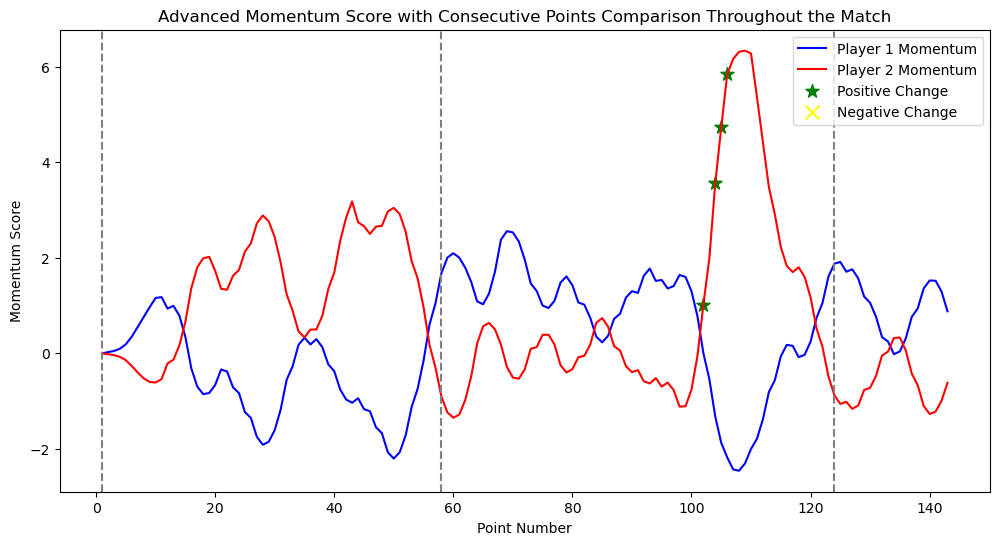

Player 1 had a Negative shift at point number 23, during set 1, game 5. GET -1.0133571697365218
Player 1 had a Positive shift at point number 81, during set 2, game 16. GET 1.1542466453514721
Player 1 had a Positive shift at point number 82, during set 2, game 16. GET 1.0531713914265488
Player 1 had a Positive shift at point number 89, during set 2, game 18. GET 1.0463005139602233
Player 1 had a Positive shift at point number 94, during set 2, game 19. GET 1.0839400403866257
Player 1 had a Negative shift at point number 95, during set 2, game 19. GET -1.4748145738634424
Player 1 had a Negative shift at point number 96, during set 2, game 19. GET -1.3686333282809624
Player 1 had a Negative shift at point number 97, during set 2, game 19. GET -1.3331815304960601
Player 1 had a Negative shift at point number 98, during set 2, game 19. GET -1.3229581683212173
Player 1 had a Negative shift at point number 99, during set 2, game 19. GET -1.3450684538509012


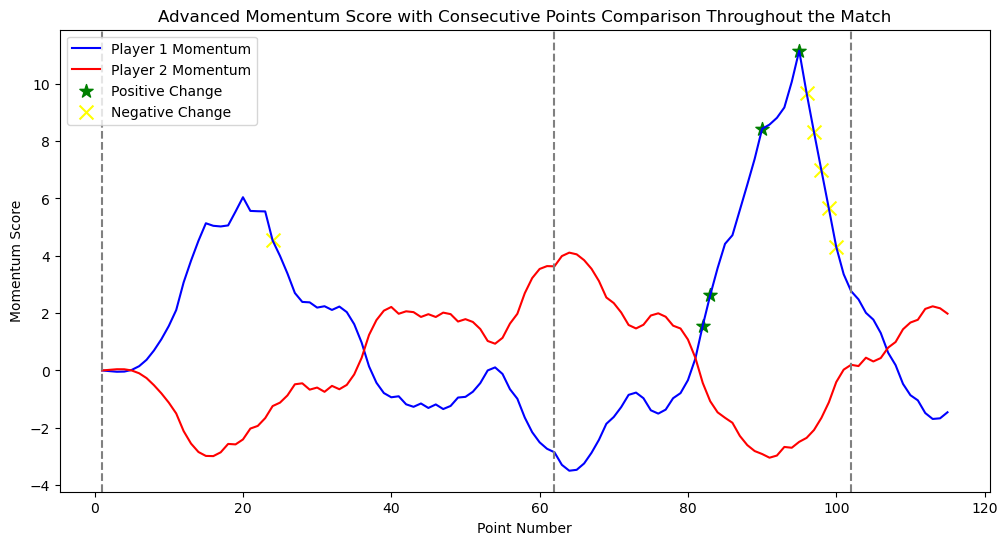

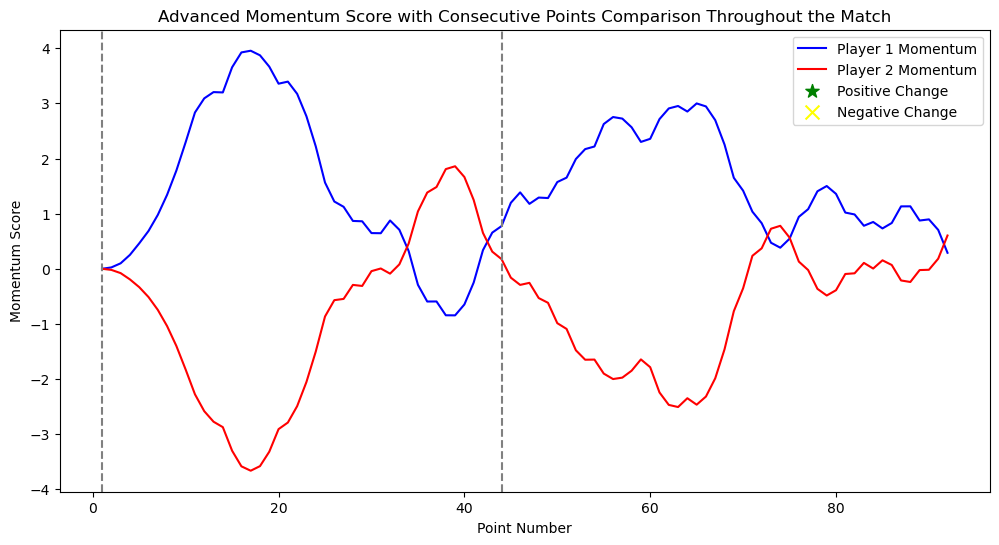

Player 1 had a Positive shift at point number 71, during set 2, game 15. GET 1.0713676028314434
Player 1 had a Positive shift at point number 74, during set 2, game 15. GET 1.0955788912476097


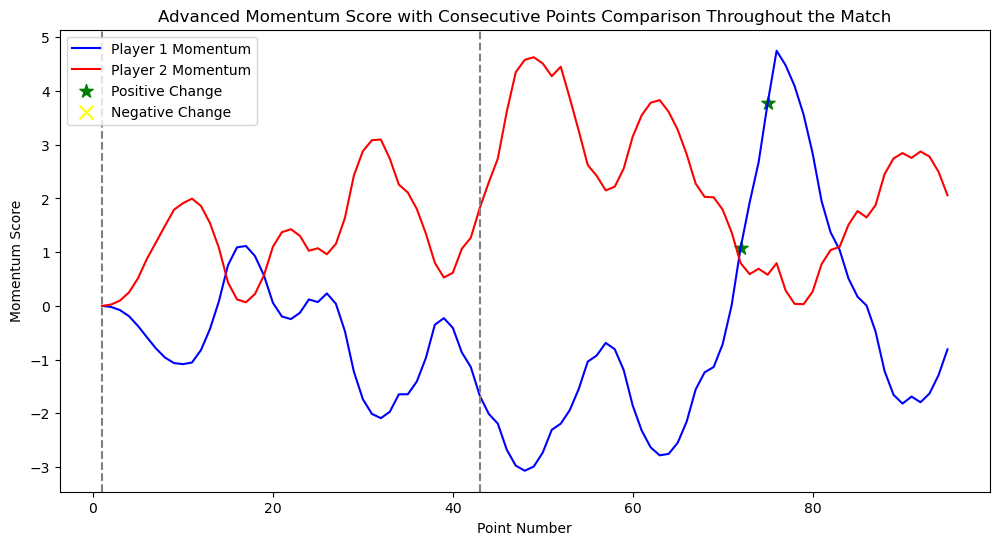

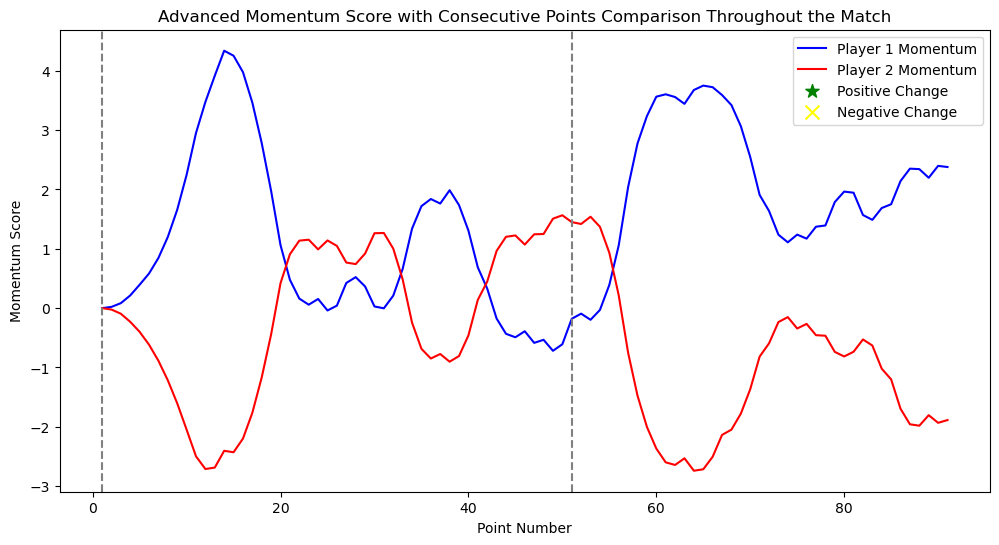

Player 1 had a Positive shift at point number 18, during set 1, game 4. GET 1.027889198324249
Player 1 had a Positive shift at point number 71, during set 2, game 14. GET 1.0593248472969545
Player 2 had a Positive shift at point number 102, during set 2, game 20. GET 1.2288983141152567
Player 2 had a Positive shift at point number 105, during set 2, game 20. GET 1.0820302209806458
Player 2 had a Negative shift at point number 112, during set 2, game 21. GET -1.0269517259338046
Player 2 had a Negative shift at point number 113, during set 2, game 22. GET -1.0091795910967605


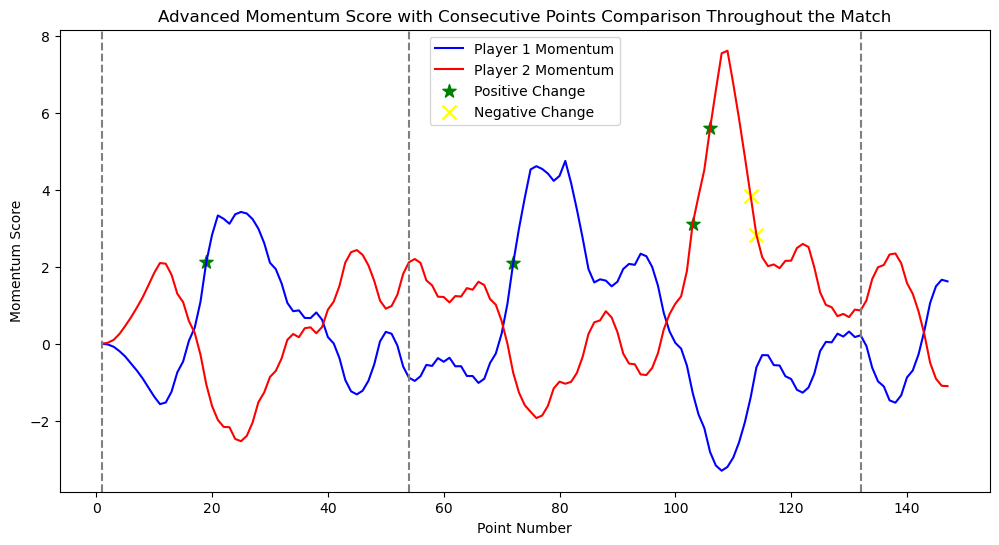

Player 1 had a Positive shift at point number 28, during set 1, game 6. GET 1.1383442485958022
Player 1 had a Positive shift at point number 29, during set 1, game 6. GET 1.198293685002064


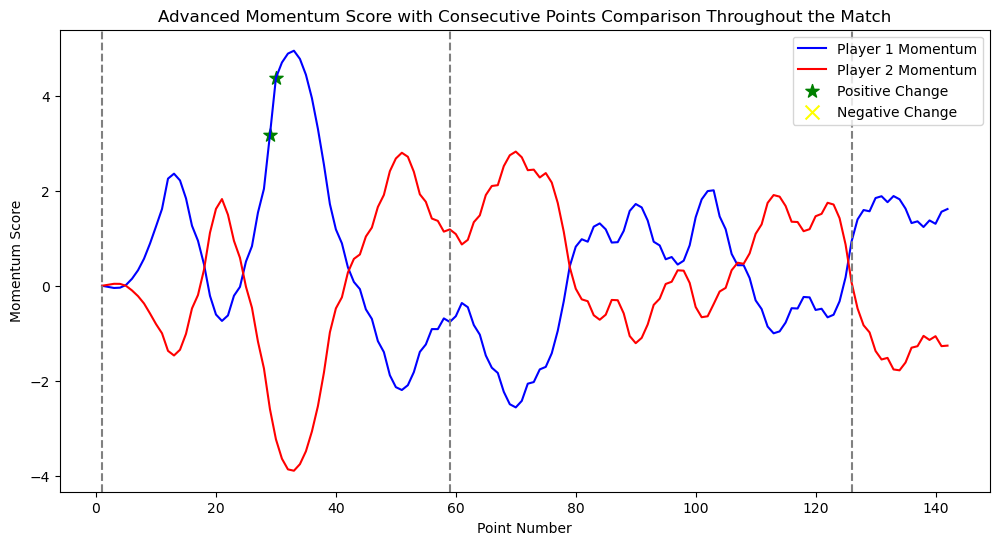

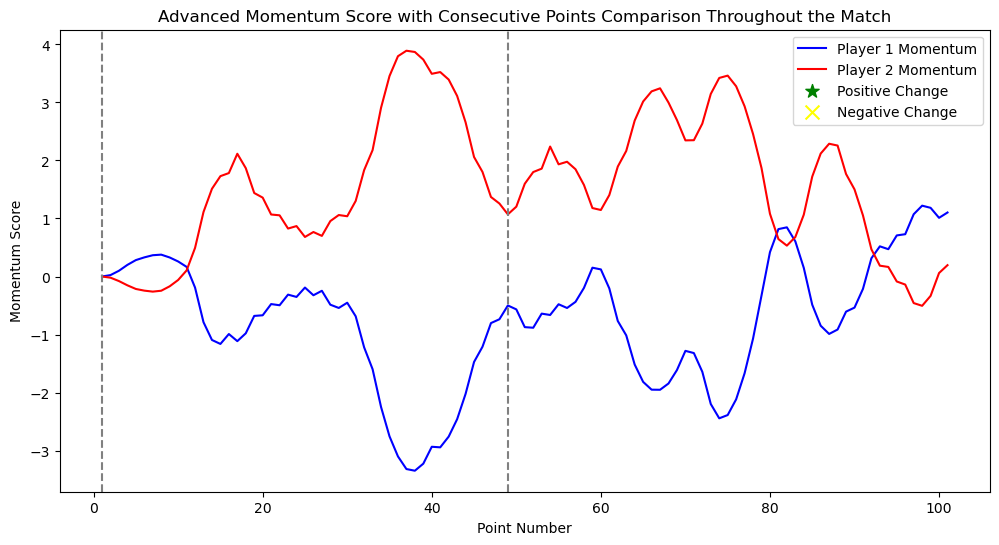

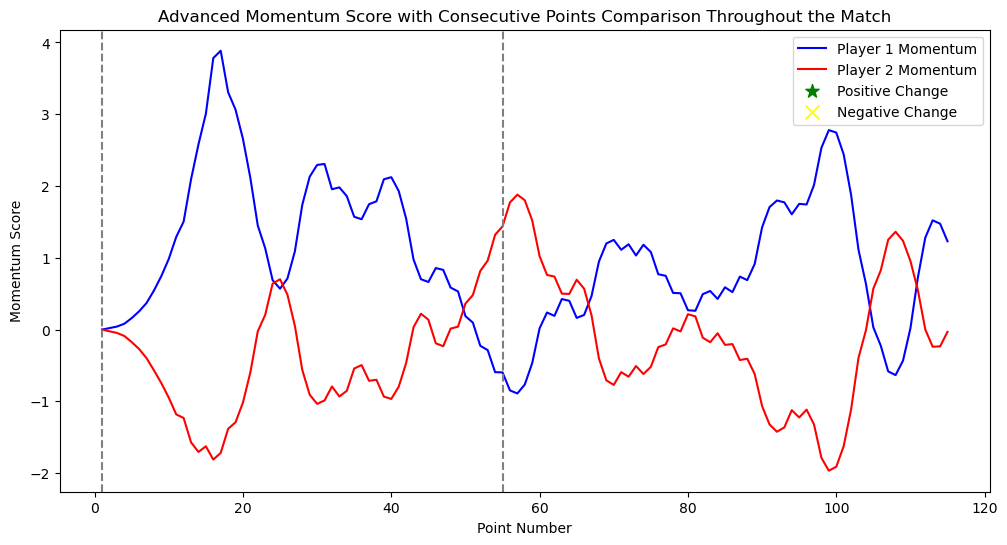

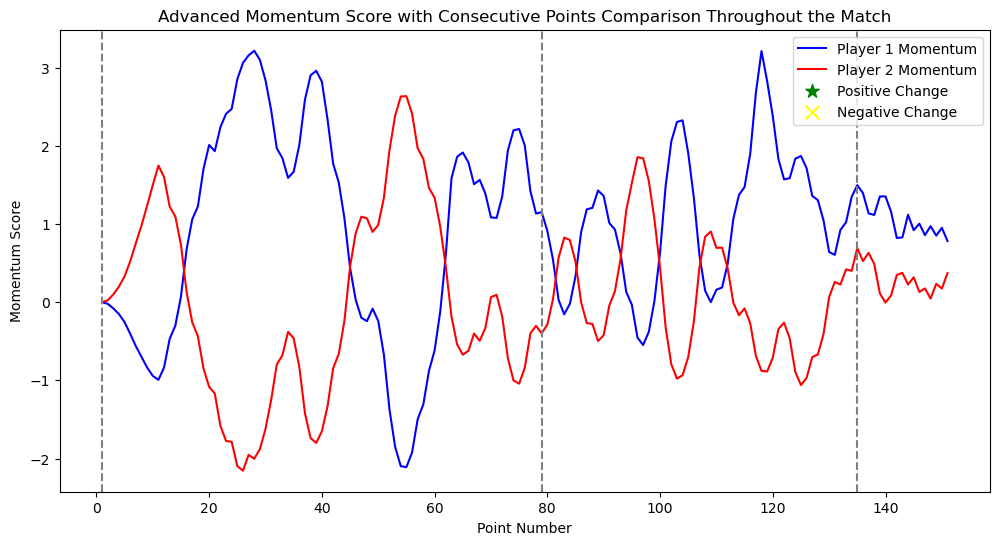

Player 1 had a Negative shift at point number 41, during set 1, game 9. GET -1.4115911687581582
Player 1 had a Negative shift at point number 42, during set 1, game 9. GET -1.4068479902660291
Player 1 had a Negative shift at point number 44, during set 1, game 9. GET -1.0488783916642186
Player 1 had a Negative shift at point number 45, during set 1, game 9. GET -1.1045075715262795
Player 1 had a Negative shift at point number 46, during set 1, game 9. GET -1.2075595159092338


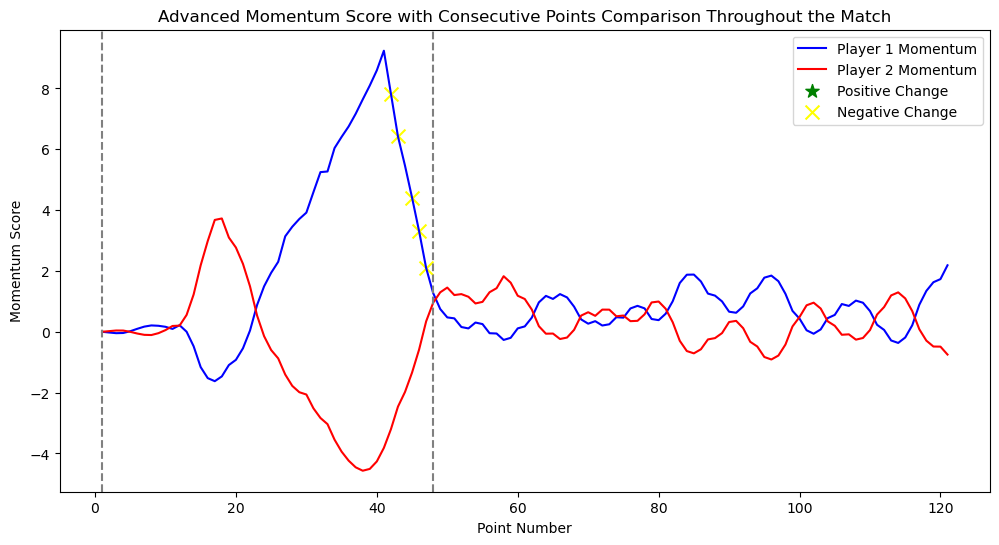

Player 2 had a Positive shift at point number 82, during set 2, game 15. GET 1.0482456762843306


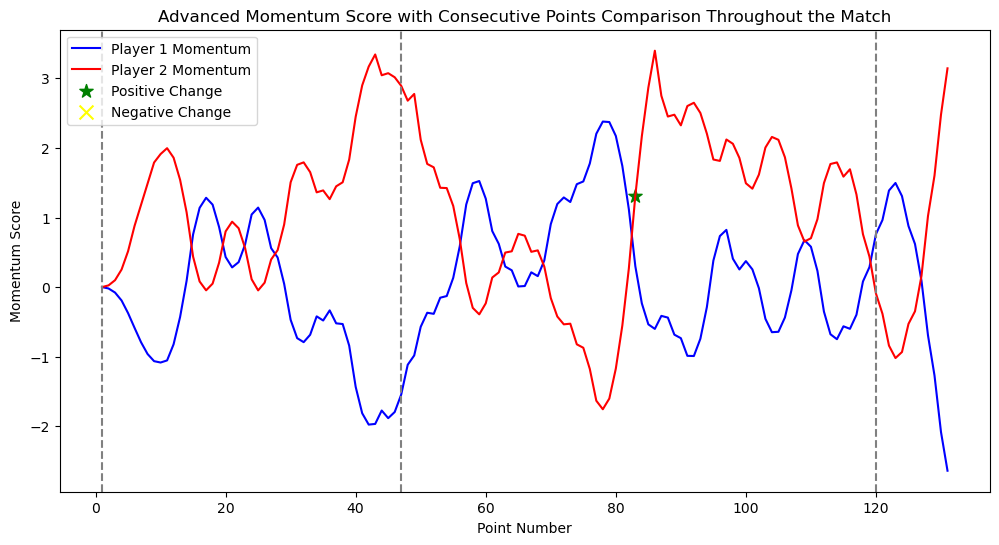

Player 1 had a Positive shift at point number 48, during set 1, game 9. GET 1.0245504612887038
Player 1 had a Negative shift at point number 63, during set 2, game 12. GET -1.0439074519196194
Player 1 had a Negative shift at point number 64, during set 2, game 13. GET -1.1038319252699051


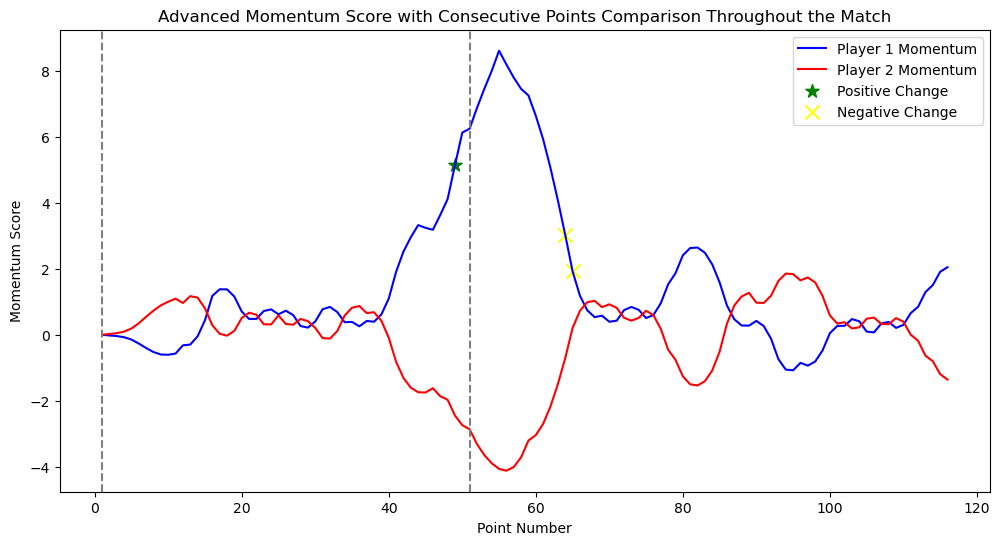

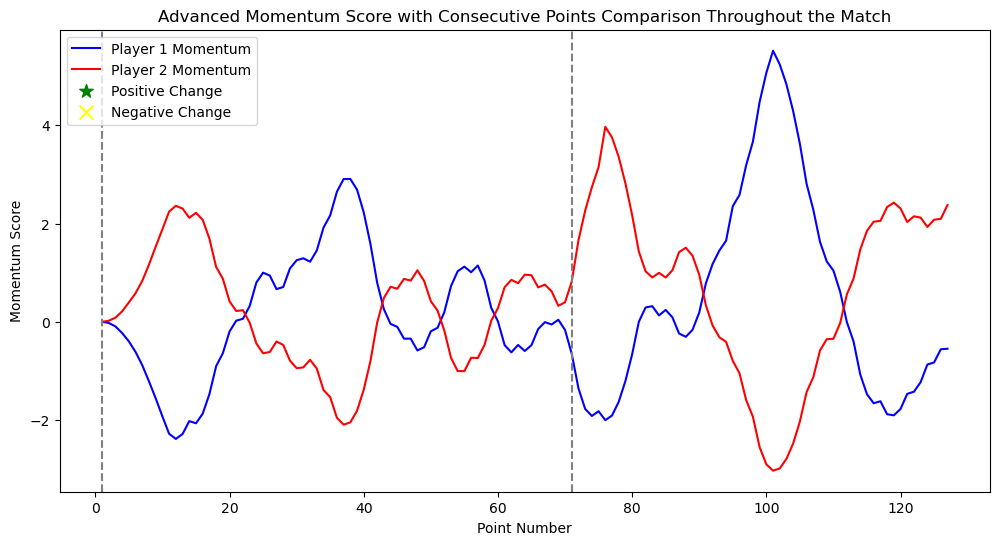

Player 1 had a Positive shift at point number 52, during set 2, game 11. GET 1.059630882038487
Player 2 had a Positive shift at point number 40, during set 2, game 9. GET 1.5598097262171517
Player 2 had a Positive shift at point number 41, during set 2, game 9. GET 1.9135610626309232
Player 2 had a Positive shift at point number 42, during set 2, game 9. GET 1.5005101848279079
Player 2 had a Positive shift at point number 43, during set 2, game 9. GET 1.708816711265932
Player 2 had a Negative shift at point number 47, during set 2, game 10. GET -1.3383089704854214
Player 2 had a Negative shift at point number 48, during set 2, game 10. GET -1.309912821741639
Player 2 had a Negative shift at point number 49, during set 2, game 10. GET -1.318265805669406
Player 2 had a Negative shift at point number 50, during set 2, game 10. GET -1.3490044434740147
Player 2 had a Negative shift at point number 51, during set 2, game 10. GET -1.3350262847758847
Player 2 had a Negative shift at point numb

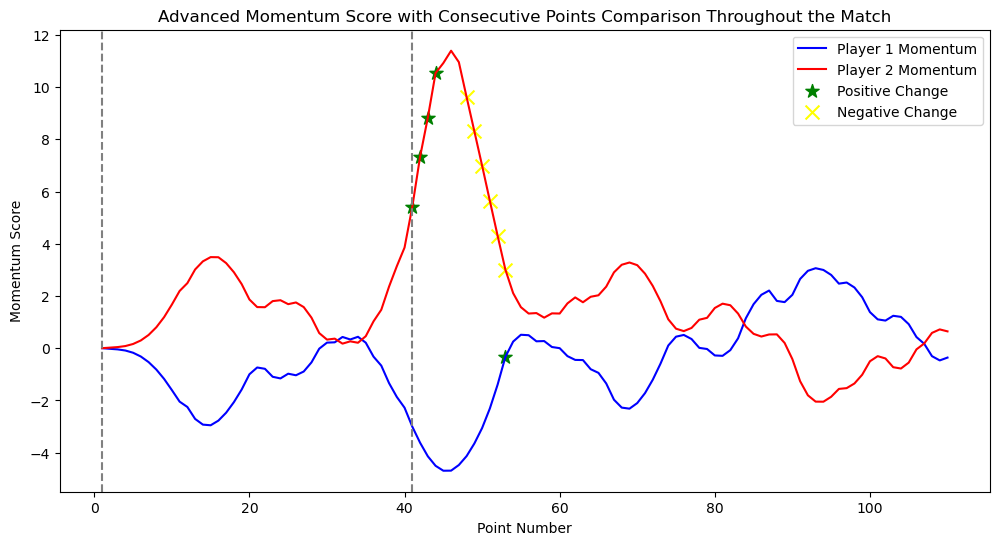

Player 2 had a Positive shift at point number 14, during set 1, game 3. GET 1.132057877223343
Player 2 had a Positive shift at point number 15, during set 1, game 3. GET 1.0185990737754316


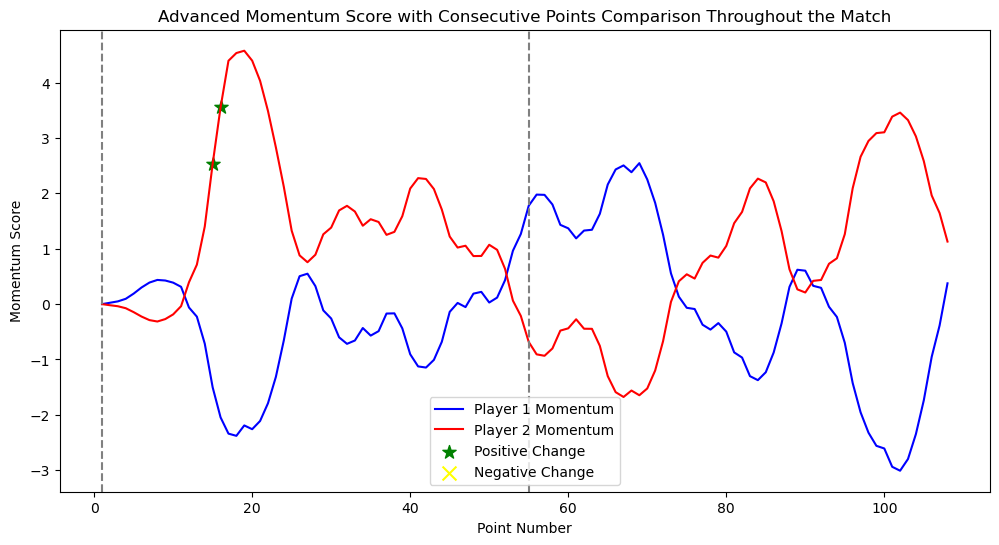

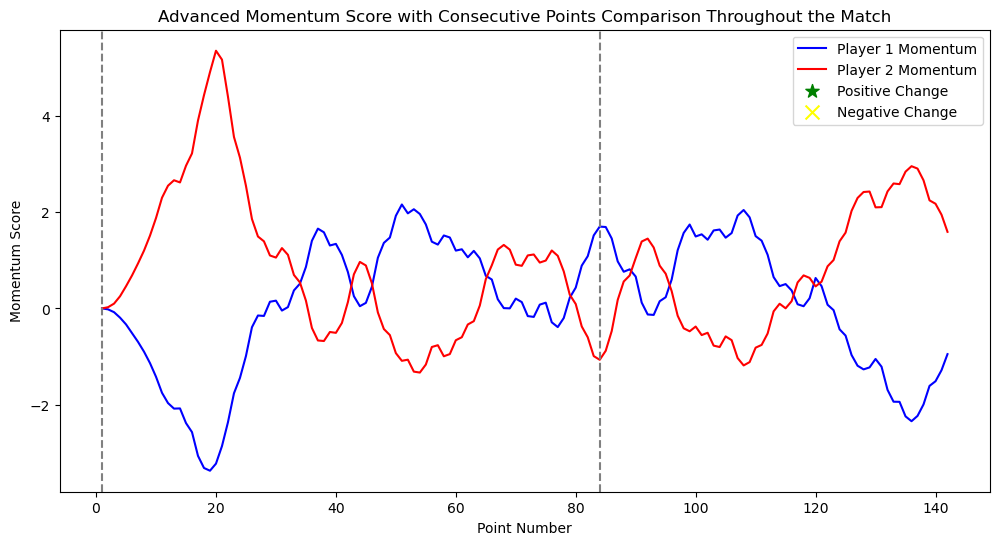

Player 1 had a Positive shift at point number 29, during set 1, game 7. GET 1.000227147120642
Player 1 had a Positive shift at point number 33, during set 1, game 7. GET 1.0244374865641293
Player 1 had a Negative shift at point number 45, during set 2, game 10. GET -1.181771425601025
Player 1 had a Negative shift at point number 46, during set 2, game 10. GET -1.091735057425403
Player 1 had a Negative shift at point number 47, during set 2, game 10. GET -1.0057705711965133
Player 1 had a Negative shift at point number 51, during set 2, game 11. GET -1.0290492848292923
Player 1 had a Positive shift at point number 76, during set 2, game 15. GET 1.1650893929538348


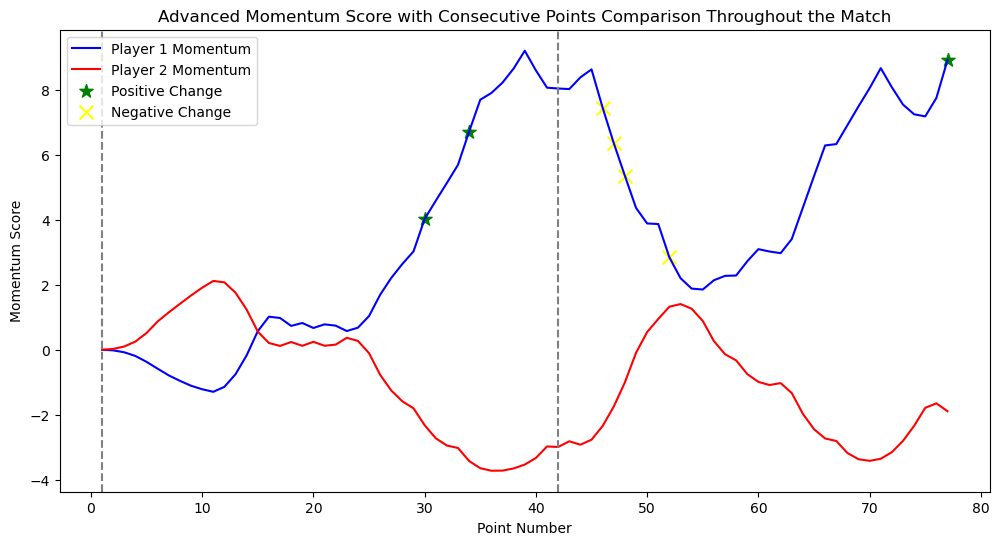

Player 1 had a Positive shift at point number 11, during set 1, game 3. GET 1.0766662503180155
Player 2 had a Positive shift at point number 111, during set 3, game 19. GET 1.1804165208572694
Player 2 had a Negative shift at point number 119, during set 3, game 19. GET -1.0469479149496101


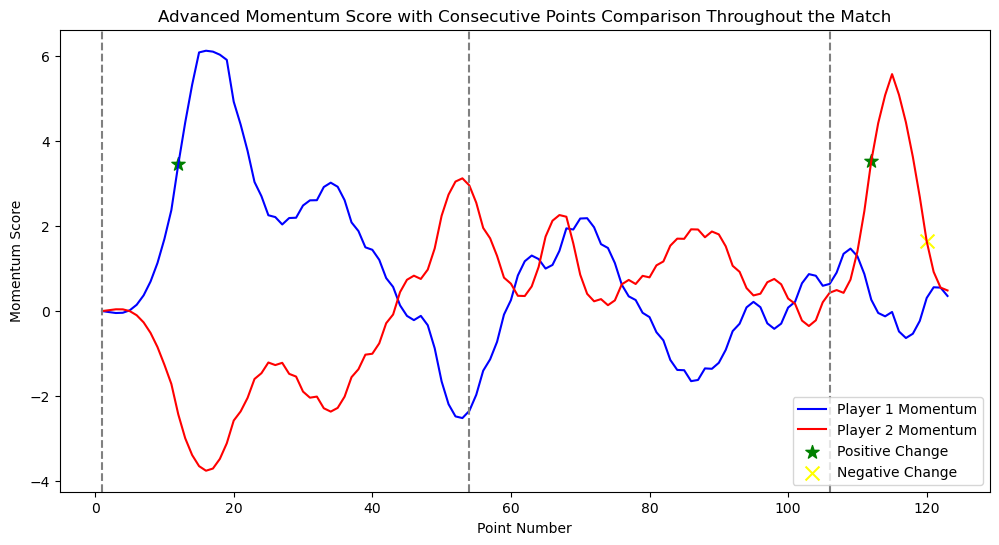

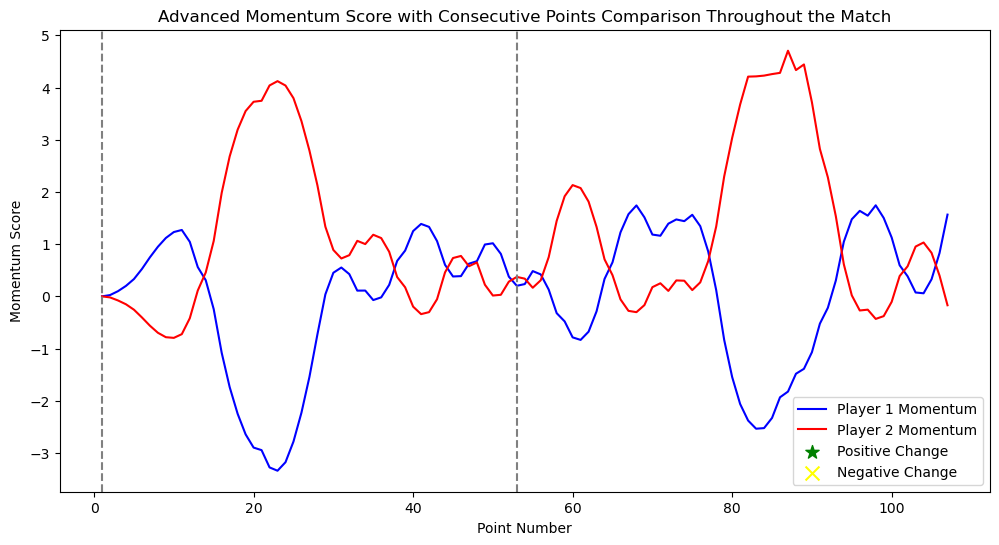

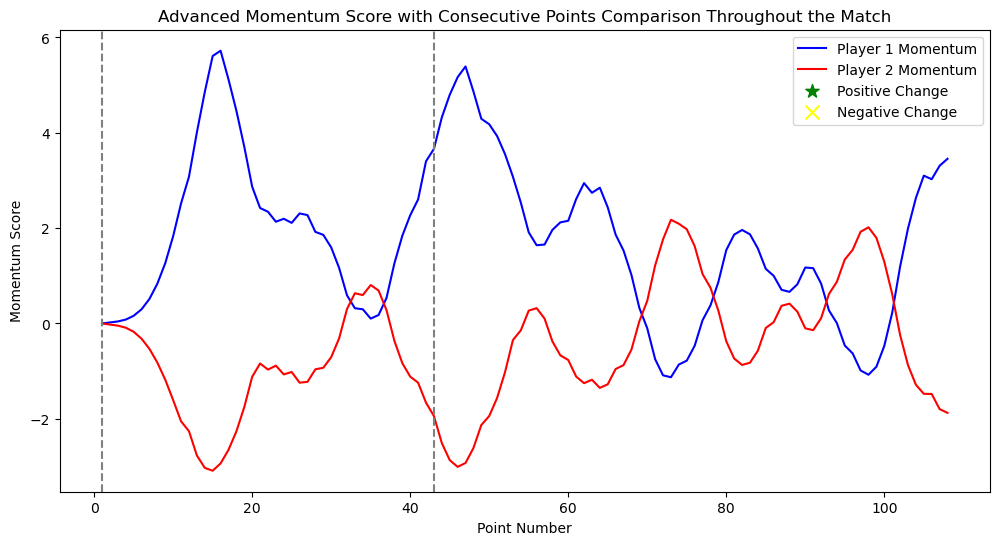

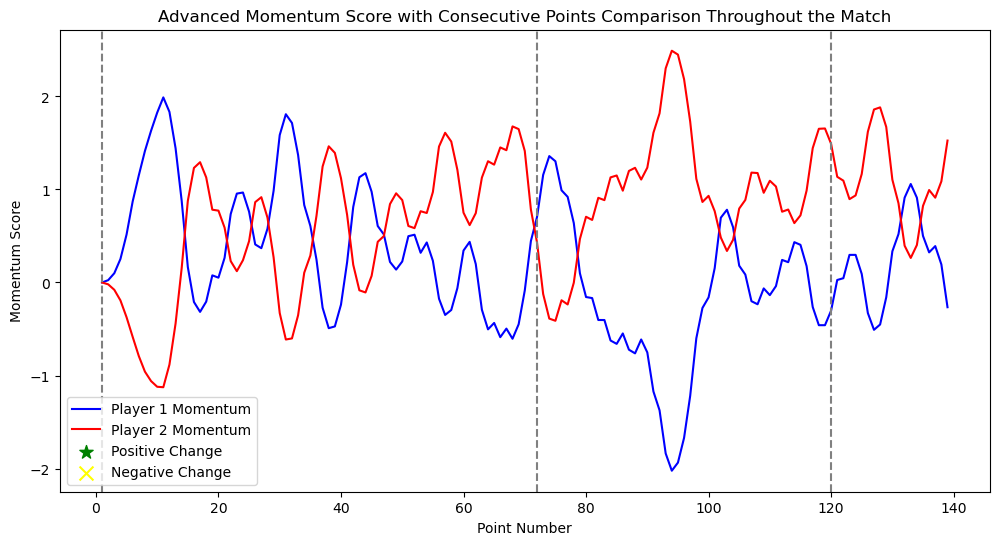

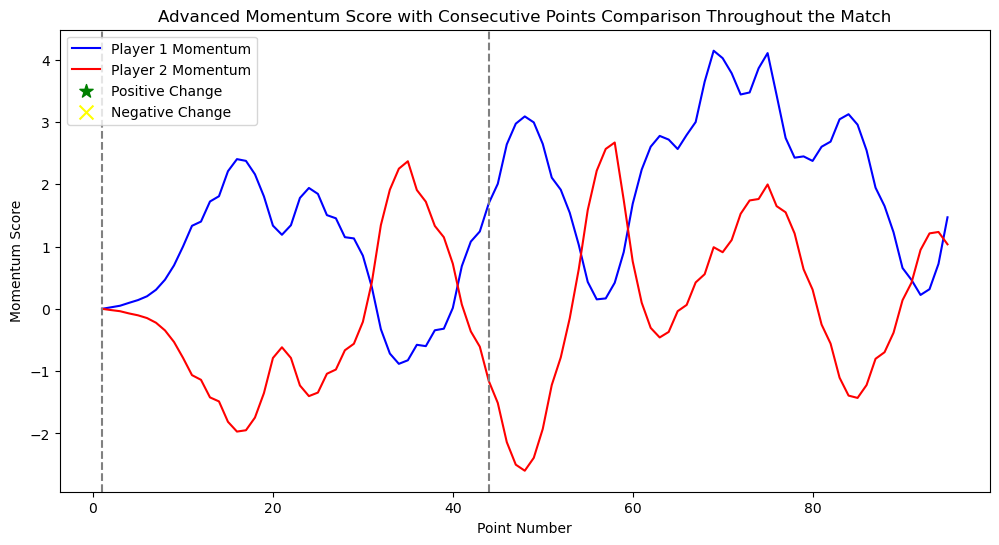

Player 1 had a Positive shift at point number 45, during set 1, game 9. GET 1.2736301427117425
Player 1 had a Positive shift at point number 46, during set 1, game 9. GET 1.092748132783453
Player 1 had a Positive shift at point number 47, during set 1, game 9. GET 1.0436044932948074
Player 1 had a Negative shift at point number 55, during set 2, game 11. GET -1.0496196993182654
Player 1 had a Negative shift at point number 56, during set 2, game 11. GET -1.1429397310794247
Player 1 had a Negative shift at point number 57, during set 2, game 11. GET -1.2085946952321138
Player 1 had a Negative shift at point number 60, during set 2, game 12. GET -1.1133137210833457


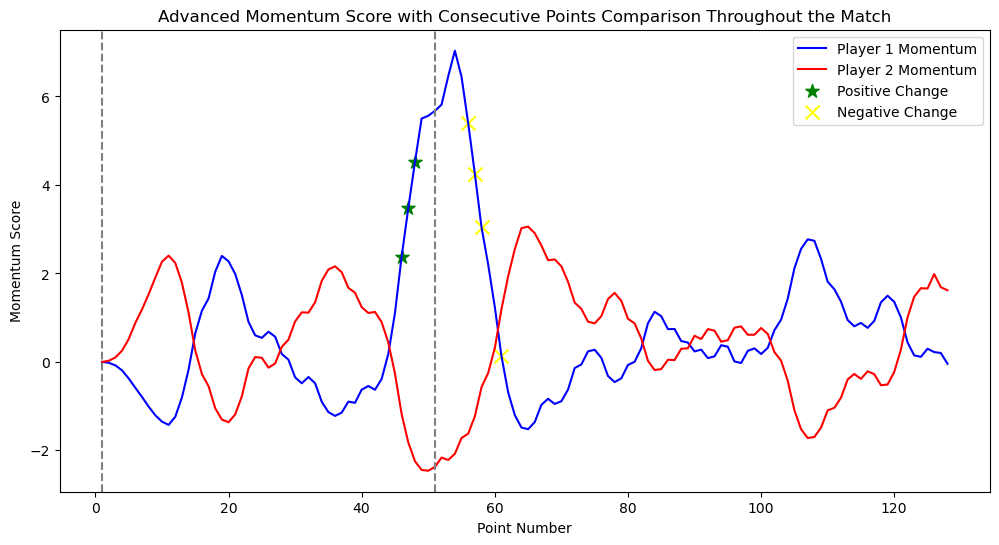

Player 2 had a Negative shift at point number 102, during set 2, game 17. GET -1.0668979140674688


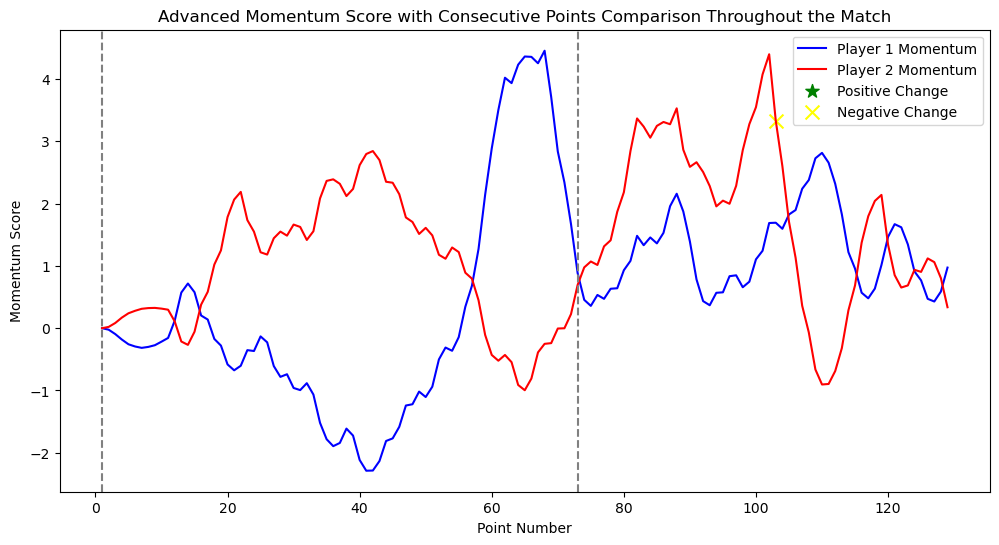

Player 1 had a Positive shift at point number 111, during set 2, game 20. GET 1.107075531157176


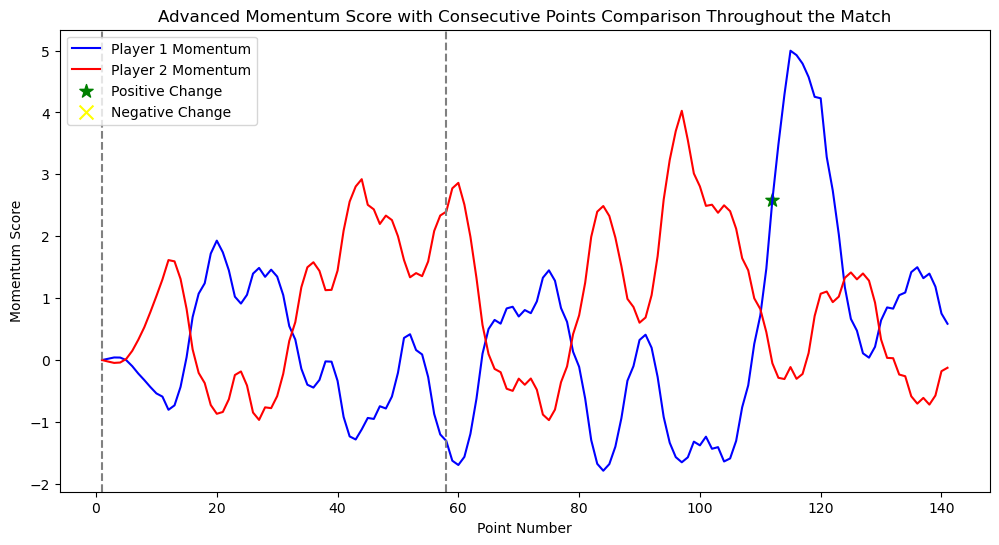

Player 1 had a Positive shift at point number 83, during set 2, game 16. GET 1.1657993662476827
Player 1 had a Positive shift at point number 84, during set 2, game 16. GET 1.1561875664413286
Player 1 had a Positive shift at point number 85, during set 2, game 16. GET 1.1696825926939782
Player 1 had a Positive shift at point number 91, during set 2, game 17. GET 1.3158346833025796
Player 1 had a Negative shift at point number 93, during set 2, game 18. GET -1.7096540750687943
Player 1 had a Negative shift at point number 94, during set 2, game 18. GET -1.6059950438199282
Player 1 had a Negative shift at point number 95, during set 2, game 18. GET -1.5218944638777474


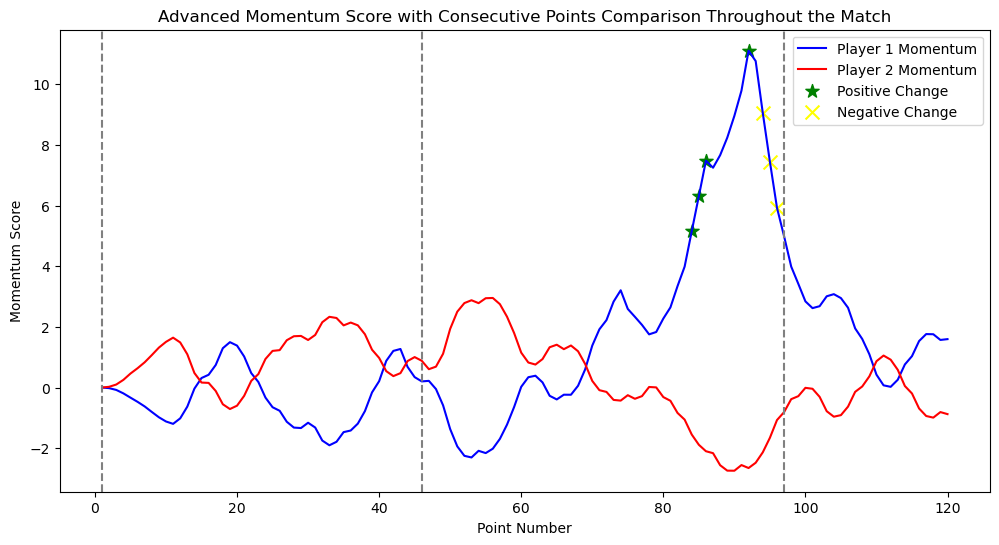

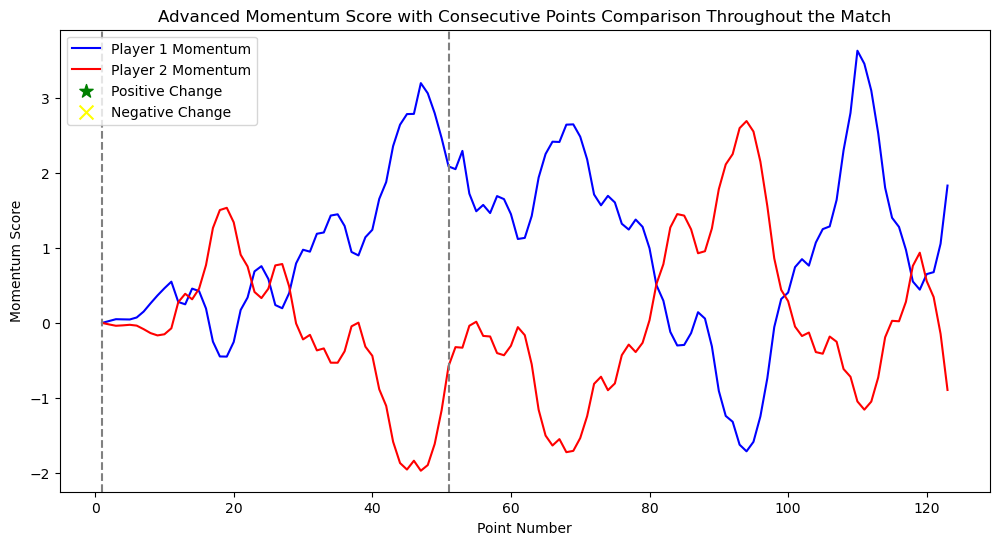

Player 1 had a Positive shift at point number 43, during set 1, game 9. GET 1.1145648089182596
Player 2 had a Positive shift at point number 29, during set 1, game 6. GET 1.0103969986251933
Player 2 had a Positive shift at point number 31, during set 1, game 7. GET 1.0283756825686536
Player 2 had a Negative shift at point number 35, during set 1, game 7. GET -1.0503936390542528
Player 2 had a Negative shift at point number 36, during set 1, game 7. GET -1.16999138886476


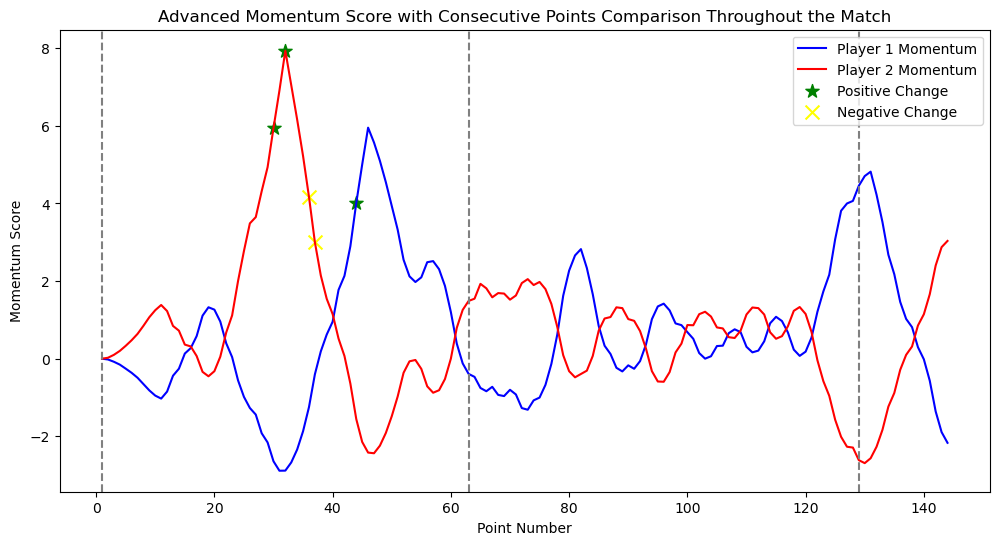

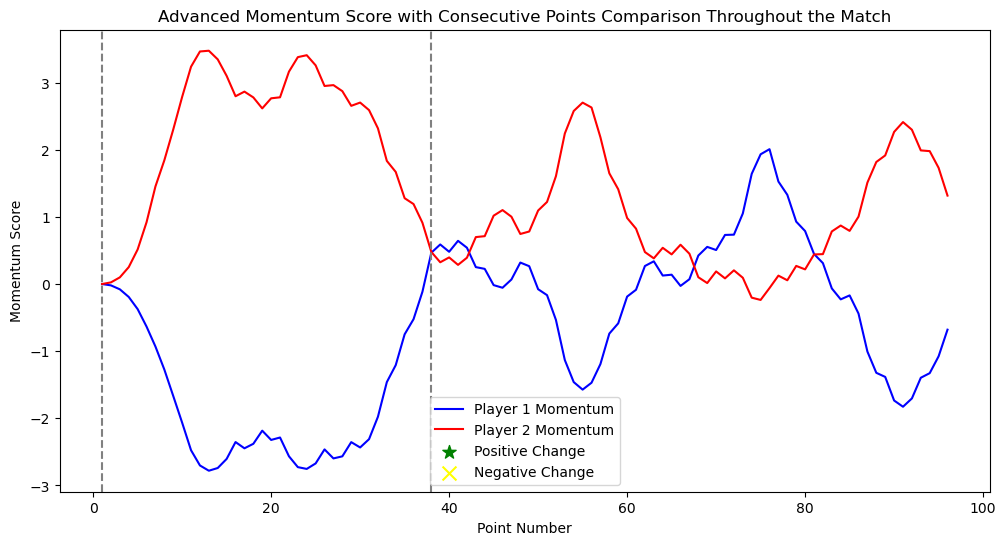

Player 1 had a Positive shift at point number 43, during set 1, game 8. GET 1.027619617737682
Player 1 had a Positive shift at point number 44, during set 1, game 8. GET 1.2584505880163959
Player 2 had a Positive shift at point number 88, during set 2, game 17. GET 1.0166126972591156
Player 2 had a Negative shift at point number 94, during set 2, game 18. GET -1.1869652427929216
Player 2 had a Negative shift at point number 95, during set 2, game 18. GET -1.153938532011897


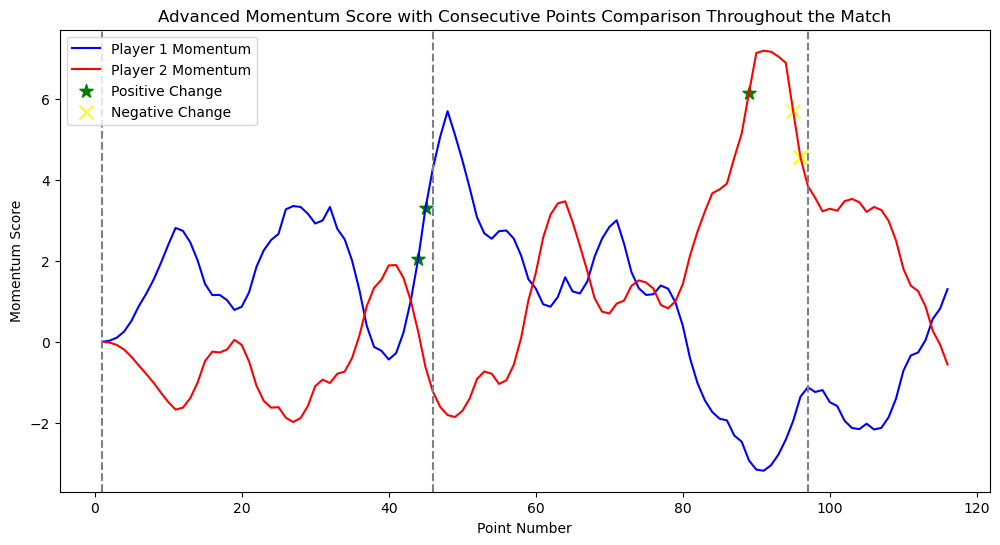

In [6]:
"""
画图
"""
target_match_ids = updated_ausopen_data['match_id'].unique().tolist()
for target_match_id in target_match_ids:
    # 筛选数据
    filtered_data = updated_ausopen_data[updated_ausopen_data['match_id'] == target_match_id].copy()

    # 计算综合势头得分
    filtered_data['comprehensive_momentum_1'] = calculate_comprehensive_momentum(filtered_data, player_number=1)
    filtered_data['comprehensive_momentum_2'] = calculate_comprehensive_momentum(filtered_data, player_number=2)

    # Define the threshold for a significant momentum shift
    threshold = 1.0

    # Initialize lists to store the points of positive and negative shifts for both players
    shifts_player_1 = []
    shifts_player_2 = []

    # Calculate the momentum change for each point and find shifts
    for i in range(1, len(filtered_data)):
        change_1 = filtered_data['comprehensive_momentum_1'].iloc[i] - filtered_data['comprehensive_momentum_1'].iloc[
            i - 1]
        change_2 = filtered_data['comprehensive_momentum_2'].iloc[i] - filtered_data['comprehensive_momentum_2'].iloc[
            i - 1]

        if abs(change_1) >= threshold:
            shift_type = 'Positive' if change_1 > 0 else 'Negative'
            shifts_player_1.append((i, shift_type, change_1))
        if abs(change_2) >= threshold:
            shift_type = 'Positive' if change_2 > 0 else 'Negative'
            shifts_player_2.append((i, shift_type, change_2))

    # Annotation
    for point, shift_type, change in shifts_player_1:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(
            f"Player 1 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")

    for point, shift_type, change in shifts_player_2:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(
            f"Player 2 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")

    # # 筛选出破发成功的点（缺失）
    # break_points_won_1 = filtered_data[filtered_data['p1_break_pt_won'] == 1]
    # break_points_won_2 = filtered_data[filtered_data['p2_break_pt_won'] == 1]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_1'], label='Player 1 Momentum',
             color='blue')
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_2'], label='Player 2 Momentum',
             color='red')

    plt.scatter([], [], color='green', marker='*', s=100, label='Positive Change')
    plt.scatter([], [], color='yellow', marker='x', s=100, label='Negative Change')

    for point, shift_type, _ in shifts_player_1:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'yellow'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point],
                    color=color, marker=marker, s=100)

    for point, shift_type, _ in shifts_player_2:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'yellow'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_2'].iloc[point],
                    color=color, marker=marker, s=100)

    # # 用黑色点标记破发成功的点（缺失）
    # plt.scatter(break_points_won_1['point_no'], break_points_won_1['comprehensive_momentum_1'], color='black',
    #             marker='o', label='Player 1 Break Points Won')
    # plt.scatter(break_points_won_2['point_no'], break_points_won_2['comprehensive_momentum_2'], color='black',
    #             marker='s', label='Player 2 Break Points Won')

    # 添加盘结束的垂直线
    last_set_no = 0
    for i, row in filtered_data.iterrows():
        if row['set_no'] != last_set_no:
            plt.axvline(x=row['point_no'], color='grey', linestyle='--')
            last_set_no = row['set_no']

    # Add labels and title to the plot
    plt.xlabel('Point Number')
    plt.ylabel('Momentum Score')
    plt.title('Advanced Momentum Score with Consecutive Points Comparison Throughout the Match')
    plt.legend()
    plt.show()
    
    # save
    filename = 'data_2018/' + target_match_id + '.csv'
    filtered_data.to_csv(filename, index=False)
    
    # # 编码发球相关特征
    # serve_width_dummies = pd.get_dummies(filtered_data['serve_width'], prefix='serve_width')
    # serve_depth_dummies = pd.get_dummies(filtered_data['serve_depth'], prefix='serve_depth')
    # return_depth_dummies = pd.get_dummies(filtered_data['return_depth'], prefix='return_depth')
    # 
    # # Concatenate the new columns with the original dataframe
    # encoded_df = pd.concat([filtered_data, serve_width_dummies, serve_depth_dummies, return_depth_dummies], axis=1)
    # new_filename = 'data_with_momentum_1hot/' + target_match_id + '.csv'
    # encoded_df.to_csv(new_filename, index=False)

In [7]:
"""
寻找转折点
"""
def find_intersections_and_changes(y1, y2, threshold=0.5, neighborhood=20):
    intersections = []
    i = 0
    while i < len(y1) - 1:
        change_1 = y1[i] - y1[i-1]
        change_2 = y2[i] - y2[i-1]
        total_change = abs(change_1) + abs(change_2)

        if total_change > threshold:
            if ((y1[i-1] > y2[i-1]) and (y1[i] < y2[i])) or ((y1[i-1] < y2[i-1]) and (y1[i] > y2[i])):
                intersection_x = i
                intersection_y = y1[i] + (y2[i] - y1[i]) / 2
                
                # 检查之后的邻域是否有其他交点
                is_valid_after = True
                for j in range(1, neighborhood):
                    if i + j < len(y1):
                        future_change_1 = y1[i+j] - y1[i+j-1]
                        future_change_2 = y2[i+j] - y2[i+j-1]
                        future_total_change = abs(future_change_1) + abs(future_change_2)
                        if future_total_change > threshold:
                            if ((y1[i+j-1] > y2[i+j-1]) and (y1[i+j] < y2[i+j])) or ((y1[i+j-1] < y2[i+j-1]) and (y1[i+j] > y2[i+j])):
                                is_valid_after = False
                                break

                # 检查之前的邻域是否有其他交点
                is_valid_before = True
                for j in range(1, min(i, neighborhood)):
                    past_change_1 = y1[i-j] - y1[i-j-1]
                    past_change_2 = y2[i-j] - y2[i-j-1]
                    past_total_change = abs(past_change_1) + abs(past_change_2)
                    if past_total_change > threshold:
                        if ((y1[i-j-1] > y2[i-j-1]) and (y1[i-j] < y2[i-j])) or ((y1[i-j-1] < y2[i-j-1]) and (y1[i-j] > y2[i-j])):
                            is_valid_before = False
                            break

                if is_valid_after or is_valid_before:
                    intersections.append((intersection_x, intersection_y, change_1, change_2))
        i += 1
    return intersections

C:\Users\19926\AppData\Local\Temp\ipykernel_8348\1193084529.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].mean(), inplace=True)
C:\Users\19926\AppData\Local\Temp\ipykernel_8348\1193084529.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].mean(), inplace=True)
C:\Users\19926\AppData\Local\Temp\ipykernel_8348\1193084529.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      143 non-null    int64
 1   p2_sets      143 non-null    int64
 2   p1_games     143 non-null    int64
 3   p2_games     143 non-null    int64
 4   server       143 non-null    int64
 5   speed_mph    143 non-null    int64
 6   rally_count  143 non-null    int64
 7   speed_mph    143 non-null    int64
dtypes: int64(8)
memory usage: 9.1 KB
Match: 2018-ausopen-XD101.csv
Intersection 1: (x=18, y=0.45) - Change in Momentum 1: -2.44, Change in Momentum 2: 1.92
Match: 2018-ausopen-XD101.csv
Intersection 2: (x=60, y=0.23) - Change in Momentum 1: 0.96, Change in Momentum 2: -1.41
Match: 2018-ausopen-XD101.csv
Intersection 3: (x=71, y=0.53) - Change in Momentum 1: 2.36, Change in Momentum 2: -2.02


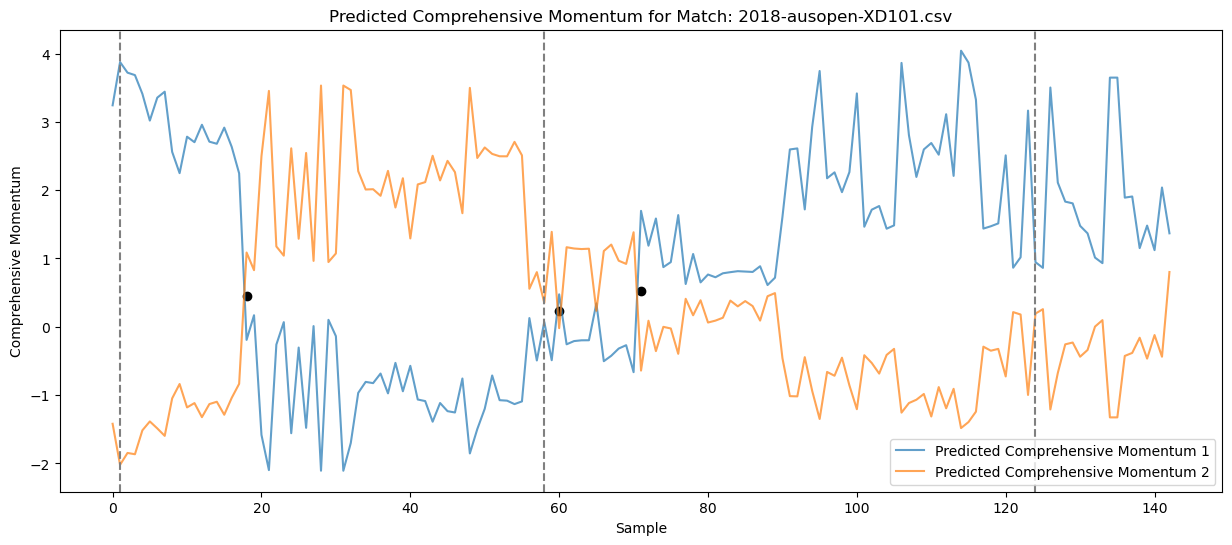

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      115 non-null    int64
 1   p2_sets      115 non-null    int64
 2   p1_games     115 non-null    int64
 3   p2_games     115 non-null    int64
 4   server       115 non-null    int64
 5   speed_mph    115 non-null    int64
 6   rally_count  115 non-null    int64
 7   speed_mph    115 non-null    int64
dtypes: int64(8)
memory usage: 7.3 KB
Match: 2018-ausopen-XD102.csv
Intersection 1: (x=21, y=0.59) - Change in Momentum 1: -3.05, Change in Momentum 2: 2.94
Match: 2018-ausopen-XD102.csv
Intersection 2: (x=29, y=0.38) - Change in Momentum 1: -1.63, Change in Momentum 2: 1.32
Match: 2018-ausopen-XD102.csv
Intersection 3: (x=79, y=0.42) - Change in Momentum 1: 2.56, Change in Momentum 2: -2.75


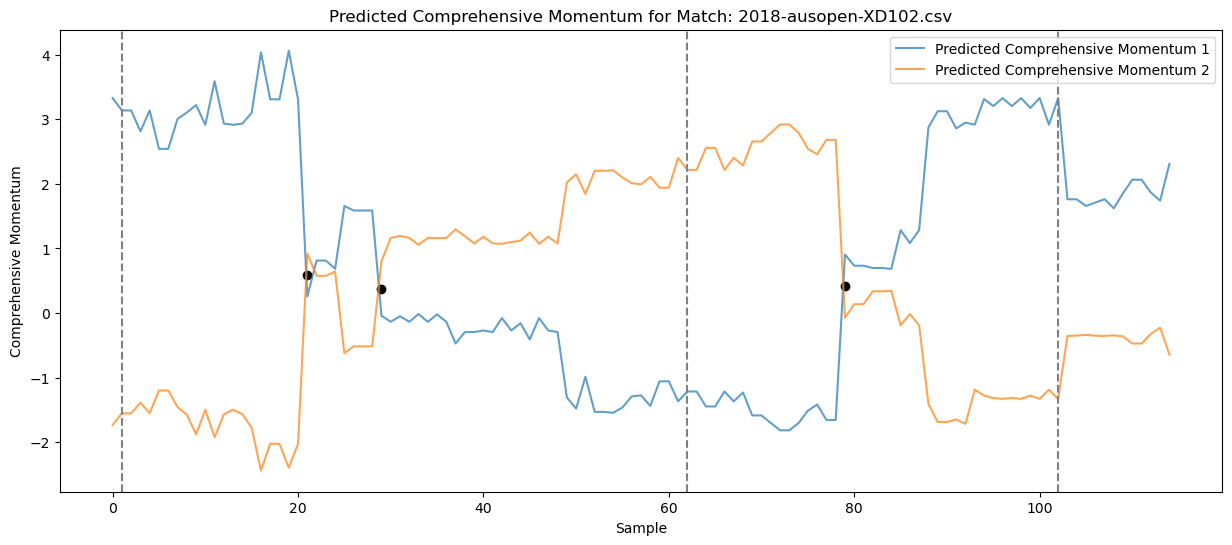

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      92 non-null     int64
 1   p2_sets      92 non-null     int64
 2   p1_games     92 non-null     int64
 3   p2_games     92 non-null     int64
 4   server       92 non-null     int64
 5   speed_mph    92 non-null     int64
 6   rally_count  92 non-null     int64
 7   speed_mph    92 non-null     int64
dtypes: int64(8)
memory usage: 5.9 KB
Match: 2018-ausopen-XD103.csv
Intersection 1: (x=5, y=0.35) - Change in Momentum 1: -0.48, Change in Momentum 2: 0.43
Match: 2018-ausopen-XD103.csv
Intersection 2: (x=26, y=0.6) - Change in Momentum 1: 2.99, Change in Momentum 2: -2.65
Match: 2018-ausopen-XD103.csv
Intersection 3: (x=64, y=0.53) - Change in Momentum 1: -1.90, Change in Momentum 2: 2.01


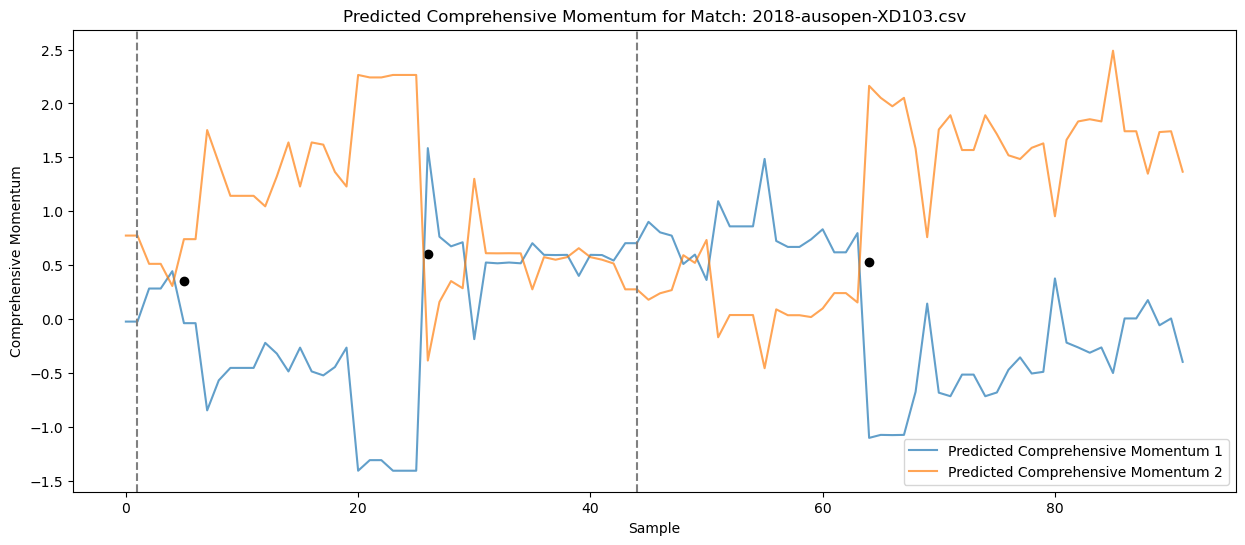

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      95 non-null     int64
 1   p2_sets      95 non-null     int64
 2   p1_games     95 non-null     int64
 3   p2_games     95 non-null     int64
 4   server       95 non-null     int64
 5   speed_mph    95 non-null     int64
 6   rally_count  95 non-null     int64
 7   speed_mph    95 non-null     int64
dtypes: int64(8)
memory usage: 6.1 KB
Match: 2018-ausopen-XD104.csv
Intersection 1: (x=0, y=0.78) - Change in Momentum 1: -1.18, Change in Momentum 2: 1.93
Match: 2018-ausopen-XD104.csv
Intersection 2: (x=8, y=0.45) - Change in Momentum 1: 1.11, Change in Momentum 2: -1.34
Match: 2018-ausopen-XD104.csv
Intersection 3: (x=25, y=0.42) - Change in Momentum 1: -0.39, Change in Momentum 2: 0.38
Match: 2018-ausopen-XD104.csv
Intersection 4: (x=65, y=0.69) - Change in Momentum 1: 1.21, Change in Mome

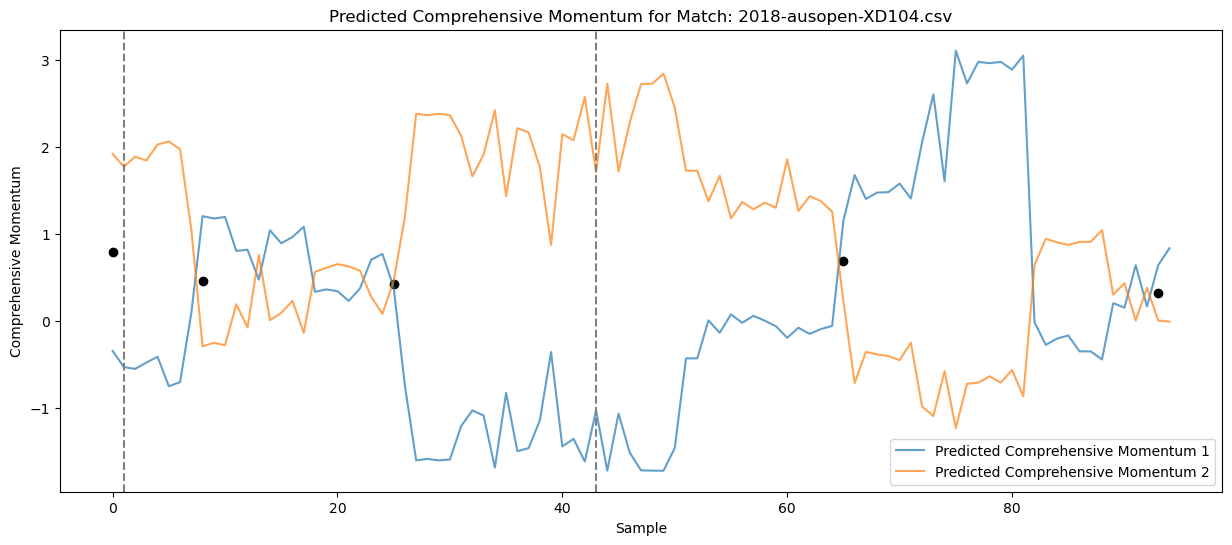

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      91 non-null     int64
 1   p2_sets      91 non-null     int64
 2   p1_games     91 non-null     int64
 3   p2_games     91 non-null     int64
 4   server       91 non-null     int64
 5   speed_mph    91 non-null     int64
 6   rally_count  91 non-null     int64
 7   speed_mph    91 non-null     int64
dtypes: int64(8)
memory usage: 5.8 KB
Match: 2018-ausopen-XD105.csv
Intersection 1: (x=0, y=0.37) - Change in Momentum 1: -2.40, Change in Momentum 2: 1.85
Match: 2018-ausopen-XD105.csv
Intersection 2: (x=8, y=0.57) - Change in Momentum 1: 1.68, Change in Momentum 2: -1.31
Match: 2018-ausopen-XD105.csv
Intersection 3: (x=78, y=0.52) - Change in Momentum 1: -0.43, Change in Momentum 2: 0.70


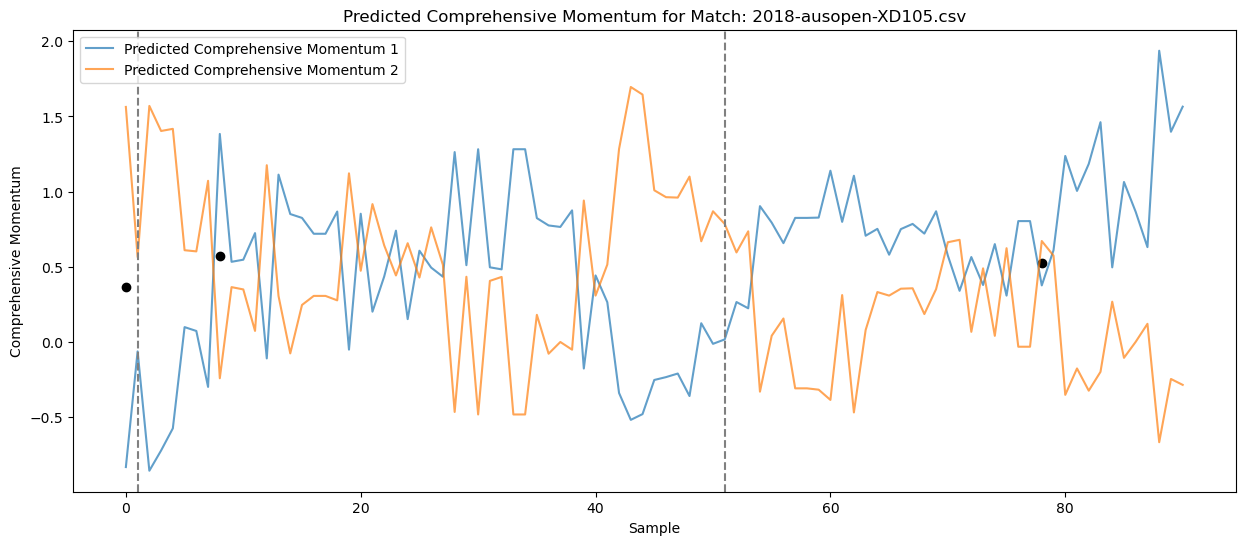

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      147 non-null    int64
 1   p2_sets      147 non-null    int64
 2   p1_games     147 non-null    int64
 3   p2_games     147 non-null    int64
 4   server       147 non-null    int64
 5   speed_mph    147 non-null    int64
 6   rally_count  147 non-null    int64
 7   speed_mph    147 non-null    int64
dtypes: int64(8)
memory usage: 9.3 KB
Match: 2018-ausopen-XD106.csv
Intersection 1: (x=32, y=0.51) - Change in Momentum 1: -0.74, Change in Momentum 2: 0.71
Match: 2018-ausopen-XD106.csv
Intersection 2: (x=67, y=0.33) - Change in Momentum 1: 0.75, Change in Momentum 2: -0.98
Match: 2018-ausopen-XD106.csv
Intersection 3: (x=92, y=0.6) - Change in Momentum 1: -1.80, Change in Momentum 2: 1.78
Match: 2018-ausopen-XD106.csv
Intersection 4: (x=126, y=0.64) - Change in Momentum 1: 1.02, Change in 

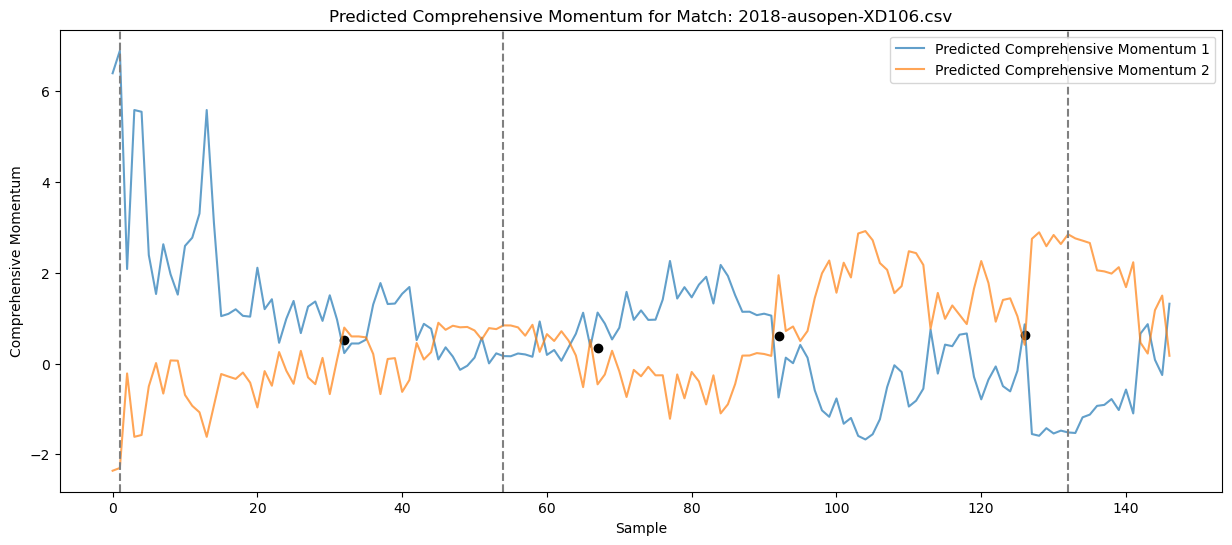

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      142 non-null    int64
 1   p2_sets      142 non-null    int64
 2   p1_games     142 non-null    int64
 3   p2_games     142 non-null    int64
 4   server       142 non-null    int64
 5   speed_mph    142 non-null    int64
 6   rally_count  142 non-null    int64
 7   speed_mph    142 non-null    int64
dtypes: int64(8)
memory usage: 9.0 KB
Match: 2018-ausopen-XD107.csv
Intersection 1: (x=10, y=0.58) - Change in Momentum 1: -1.81, Change in Momentum 2: 1.16
Match: 2018-ausopen-XD107.csv
Intersection 2: (x=41, y=0.49) - Change in Momentum 1: -3.28, Change in Momentum 2: 2.48
Match: 2018-ausopen-XD107.csv
Intersection 3: (x=87, y=0.68) - Change in Momentum 1: 1.30, Change in Momentum 2: -0.97
Match: 2018-ausopen-XD107.csv
Intersection 4: (x=92, y=0.4) - Change in Momentum 1: 1.58, Change in M

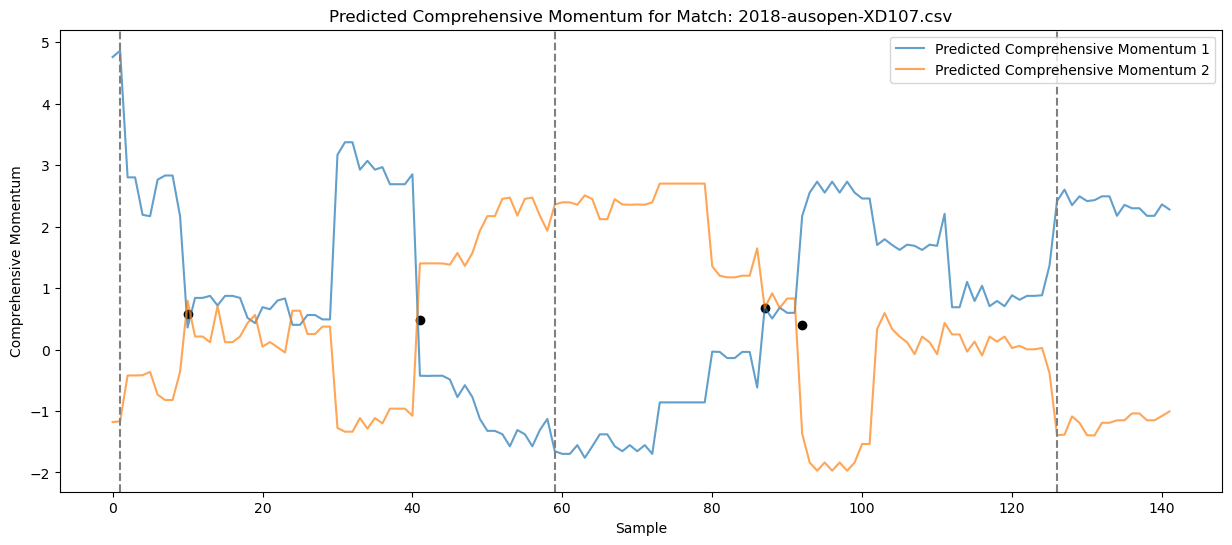

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      101 non-null    int64
 1   p2_sets      101 non-null    int64
 2   p1_games     101 non-null    int64
 3   p2_games     101 non-null    int64
 4   server       101 non-null    int64
 5   speed_mph    101 non-null    int64
 6   rally_count  101 non-null    int64
 7   speed_mph    101 non-null    int64
dtypes: int64(8)
memory usage: 6.4 KB
Match: 2018-ausopen-XD108.csv
Intersection 1: (x=0, y=1.53) - Change in Momentum 1: 6.20, Change in Momentum 2: -4.40
Match: 2018-ausopen-XD108.csv
Intersection 2: (x=6, y=0.5) - Change in Momentum 1: -4.42, Change in Momentum 2: 2.51
Match: 2018-ausopen-XD108.csv
Intersection 3: (x=37, y=0.29) - Change in Momentum 1: -1.96, Change in Momentum 2: 1.71
Match: 2018-ausopen-XD108.csv
Intersection 4: (x=72, y=0.55) - Change in Momentum 1: 2.32, Change in Mom

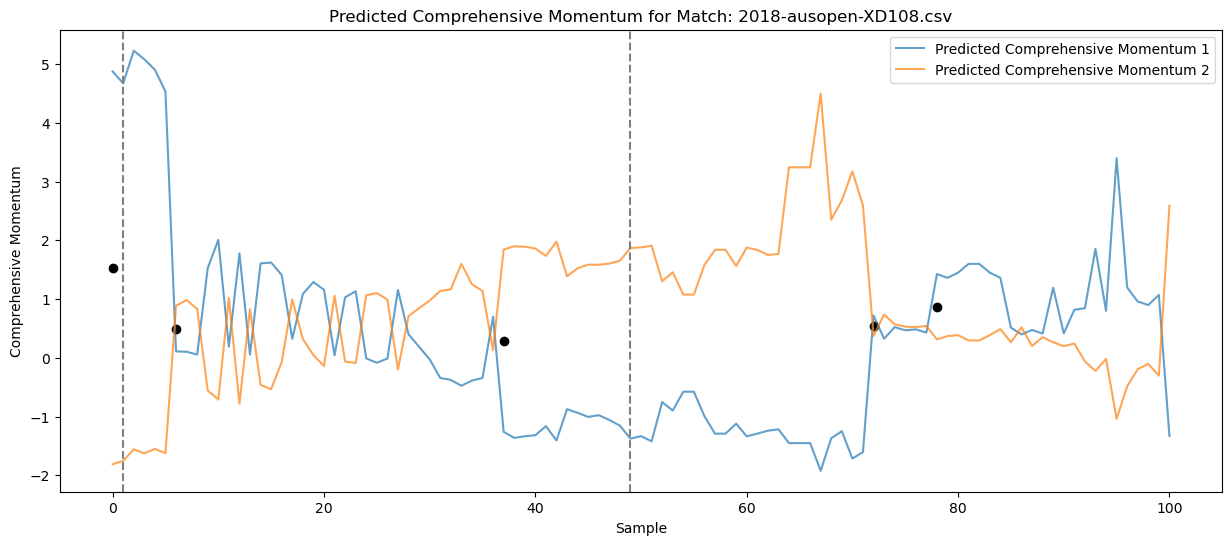

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      115 non-null    int64
 1   p2_sets      115 non-null    int64
 2   p1_games     115 non-null    int64
 3   p2_games     115 non-null    int64
 4   server       115 non-null    int64
 5   speed_mph    115 non-null    int64
 6   rally_count  115 non-null    int64
 7   speed_mph    115 non-null    int64
dtypes: int64(8)
memory usage: 7.3 KB
Match: 2018-ausopen-XD109.csv
Intersection 1: (x=0, y=0.44) - Change in Momentum 1: -0.98, Change in Momentum 2: 0.55
Match: 2018-ausopen-XD109.csv
Intersection 2: (x=10, y=0.46) - Change in Momentum 1: 2.36, Change in Momentum 2: -2.46
Match: 2018-ausopen-XD109.csv
Intersection 3: (x=77, y=0.32) - Change in Momentum 1: 0.39, Change in Momentum 2: -0.59
Match: 2018-ausopen-XD109.csv
Intersection 4: (x=109, y=0.84) - Change in Momentum 1: -0.48, Change in

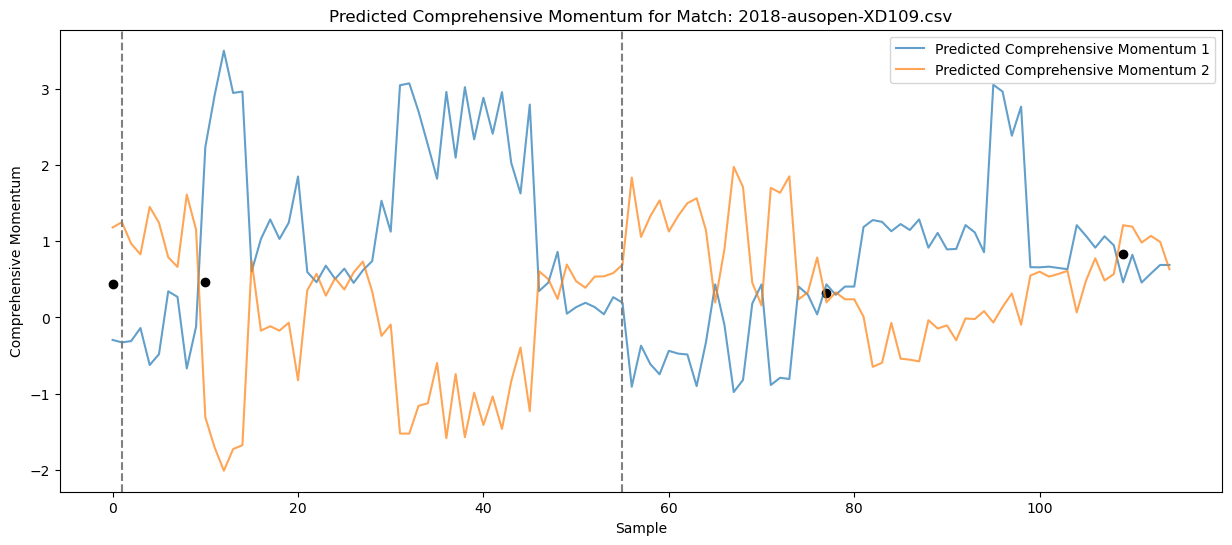

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      151 non-null    int64
 1   p2_sets      151 non-null    int64
 2   p1_games     151 non-null    int64
 3   p2_games     151 non-null    int64
 4   server       151 non-null    int64
 5   speed_mph    151 non-null    int64
 6   rally_count  151 non-null    int64
 7   speed_mph    151 non-null    int64
dtypes: int64(8)
memory usage: 9.6 KB
Match: 2018-ausopen-XD110.csv
Intersection 1: (x=0, y=0.44) - Change in Momentum 1: -1.35, Change in Momentum 2: 1.10
Match: 2018-ausopen-XD110.csv
Intersection 2: (x=1, y=0.56) - Change in Momentum 1: 0.39, Change in Momentum 2: -0.14
Match: 2018-ausopen-XD110.csv
Intersection 3: (x=13, y=0.49) - Change in Momentum 1: -0.59, Change in Momentum 2: 0.92
Match: 2018-ausopen-XD110.csv
Intersection 4: (x=44, y=0.67) - Change in Momentum 1: -1.16, Change in M

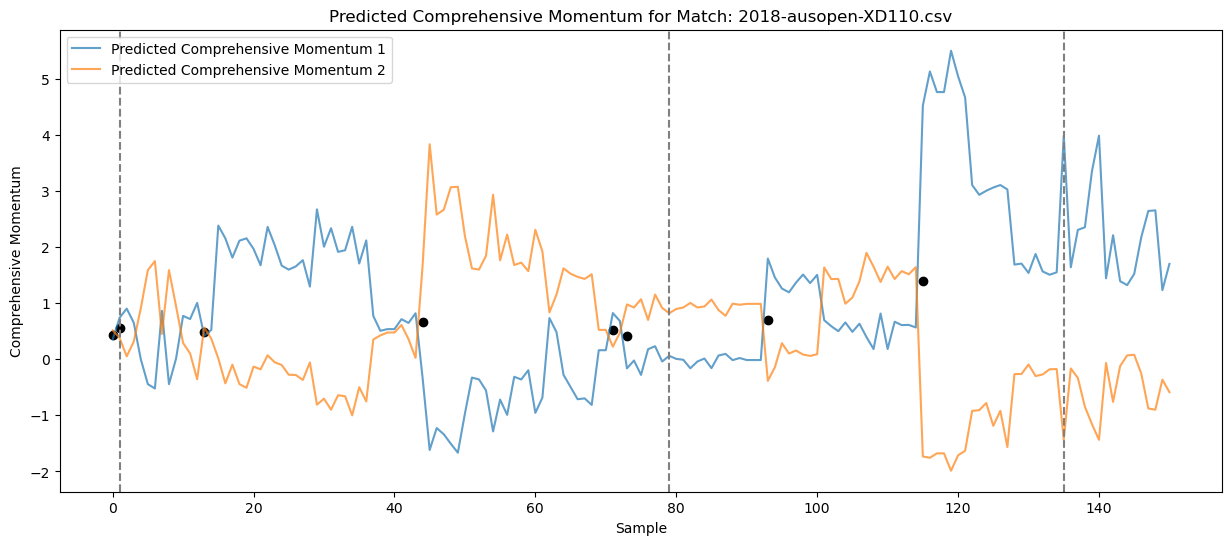

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      121 non-null    int64
 1   p2_sets      121 non-null    int64
 2   p1_games     121 non-null    int64
 3   p2_games     121 non-null    int64
 4   server       121 non-null    int64
 5   speed_mph    121 non-null    int64
 6   rally_count  121 non-null    int64
 7   speed_mph    121 non-null    int64
dtypes: int64(8)
memory usage: 7.7 KB
Match: 2018-ausopen-XD111.csv
Intersection 1: (x=0, y=0.64) - Change in Momentum 1: -1.21, Change in Momentum 2: 0.99
Match: 2018-ausopen-XD111.csv
Intersection 2: (x=1, y=0.62) - Change in Momentum 1: 0.60, Change in Momentum 2: -0.64
Match: 2018-ausopen-XD111.csv
Intersection 3: (x=37, y=1.26) - Change in Momentum 1: 0.54, Change in Momentum 2: -0.50
Match: 2018-ausopen-XD111.csv
Intersection 4: (x=62, y=0.48) - Change in Momentum 1: -1.69, Change in M

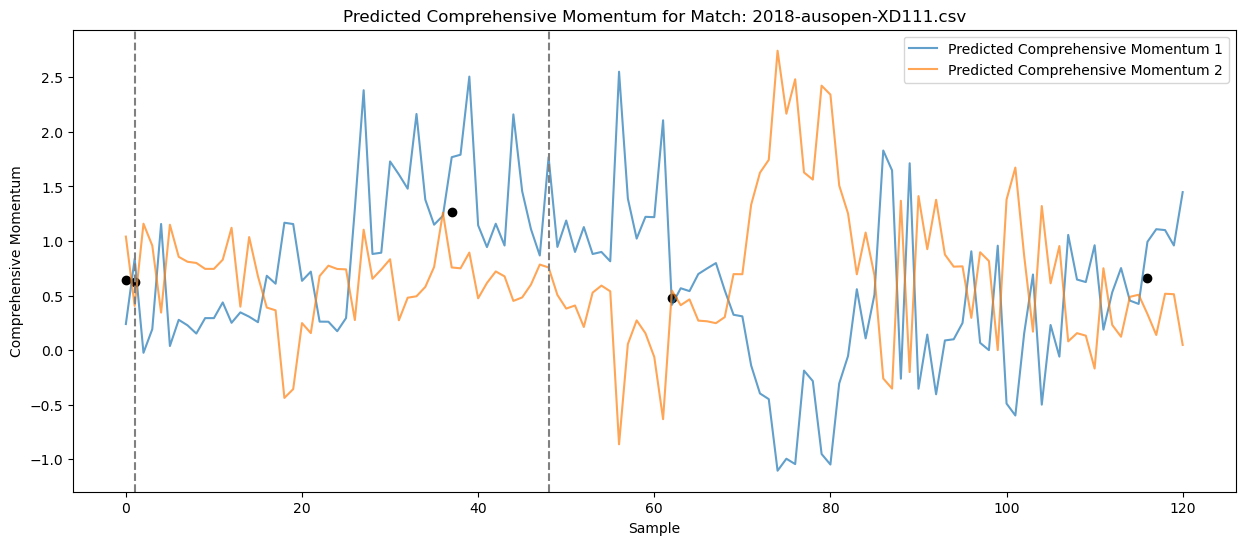

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      131 non-null    int64
 1   p2_sets      131 non-null    int64
 2   p1_games     131 non-null    int64
 3   p2_games     131 non-null    int64
 4   server       131 non-null    int64
 5   speed_mph    131 non-null    int64
 6   rally_count  131 non-null    int64
 7   speed_mph    131 non-null    int64
dtypes: int64(8)
memory usage: 8.3 KB
Match: 2018-ausopen-XD112.csv
Intersection 1: (x=12, y=0.37) - Change in Momentum 1: -2.74, Change in Momentum 2: 2.14
Match: 2018-ausopen-XD112.csv
Intersection 2: (x=33, y=0.61) - Change in Momentum 1: 1.14, Change in Momentum 2: -1.07
Match: 2018-ausopen-XD112.csv
Intersection 3: (x=69, y=0.6) - Change in Momentum 1: 3.33, Change in Momentum 2: -2.87
Match: 2018-ausopen-XD112.csv
Intersection 4: (x=90, y=1.02) - Change in Momentum 1: -0.84, Change in 

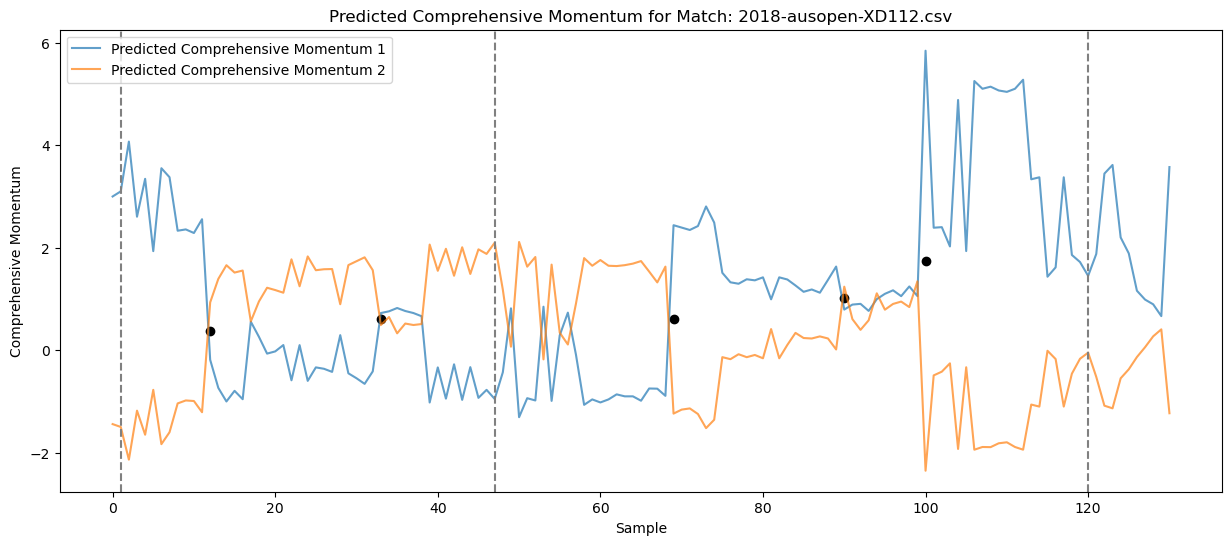

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      116 non-null    int64
 1   p2_sets      116 non-null    int64
 2   p1_games     116 non-null    int64
 3   p2_games     116 non-null    int64
 4   server       116 non-null    int64
 5   speed_mph    116 non-null    int64
 6   rally_count  116 non-null    int64
 7   speed_mph    116 non-null    int64
dtypes: int64(8)
memory usage: 7.4 KB
Match: 2018-ausopen-XD113.csv
Intersection 1: (x=0, y=0.47) - Change in Momentum 1: -1.86, Change in Momentum 2: 1.97
Match: 2018-ausopen-XD113.csv
Intersection 2: (x=22, y=0.57) - Change in Momentum 1: 1.35, Change in Momentum 2: -0.88
Match: 2018-ausopen-XD113.csv
Intersection 3: (x=107, y=0.25) - Change in Momentum 1: -1.20, Change in Momentum 2: 0.84


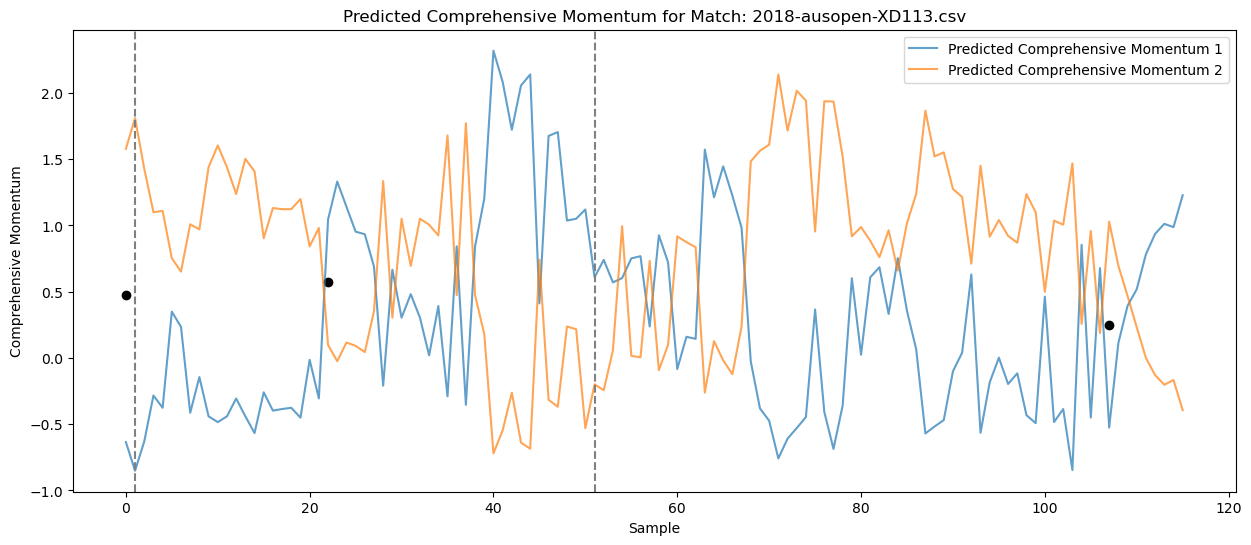

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      127 non-null    int64
 1   p2_sets      127 non-null    int64
 2   p1_games     127 non-null    int64
 3   p2_games     127 non-null    int64
 4   server       127 non-null    int64
 5   speed_mph    127 non-null    int64
 6   rally_count  127 non-null    int64
 7   speed_mph    127 non-null    int64
dtypes: int64(8)
memory usage: 8.1 KB
Match: 2018-ausopen-XD114.csv
Intersection 1: (x=5, y=0.65) - Change in Momentum 1: -1.19, Change in Momentum 2: 1.42
Match: 2018-ausopen-XD114.csv
Intersection 2: (x=89, y=0.37) - Change in Momentum 1: -0.60, Change in Momentum 2: 0.53


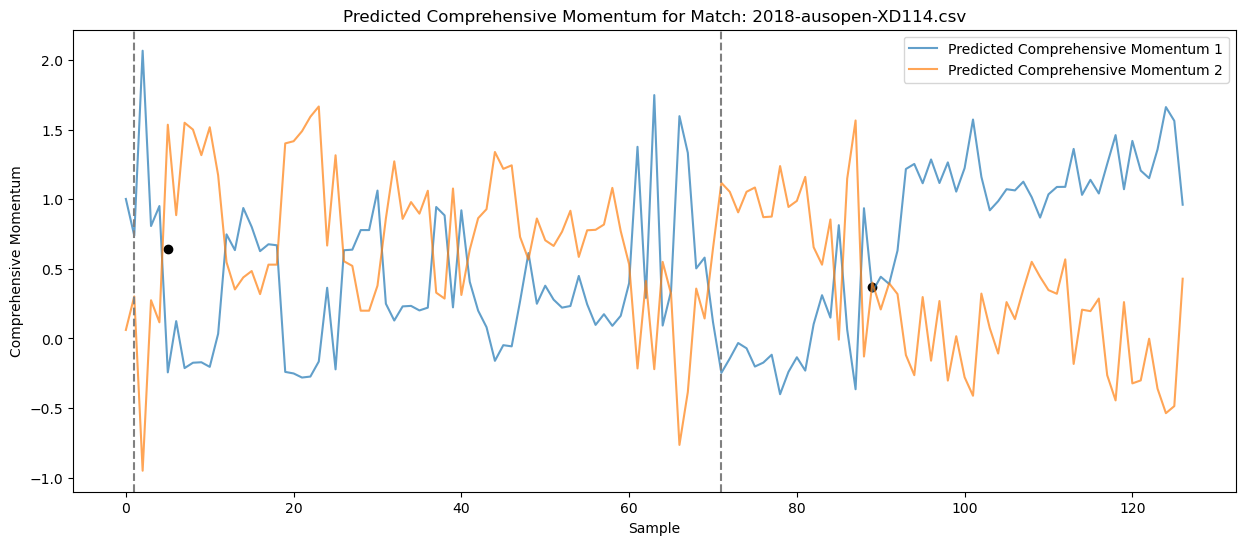

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      110 non-null    int64
 1   p2_sets      110 non-null    int64
 2   p1_games     110 non-null    int64
 3   p2_games     110 non-null    int64
 4   server       110 non-null    int64
 5   speed_mph    110 non-null    int64
 6   rally_count  110 non-null    int64
 7   speed_mph    110 non-null    int64
dtypes: int64(8)
memory usage: 7.0 KB
Match: 2018-ausopen-XD115.csv
Intersection 1: (x=0, y=0.51) - Change in Momentum 1: -3.94, Change in Momentum 2: 3.75
Match: 2018-ausopen-XD115.csv
Intersection 2: (x=13, y=0.78) - Change in Momentum 1: 4.38, Change in Momentum 2: -3.84
Match: 2018-ausopen-XD115.csv
Intersection 3: (x=31, y=0.42) - Change in Momentum 1: -3.17, Change in Momentum 2: 2.43
Match: 2018-ausopen-XD115.csv
Intersection 4: (x=76, y=0.42) - Change in Momentum 1: 1.97, Change in M

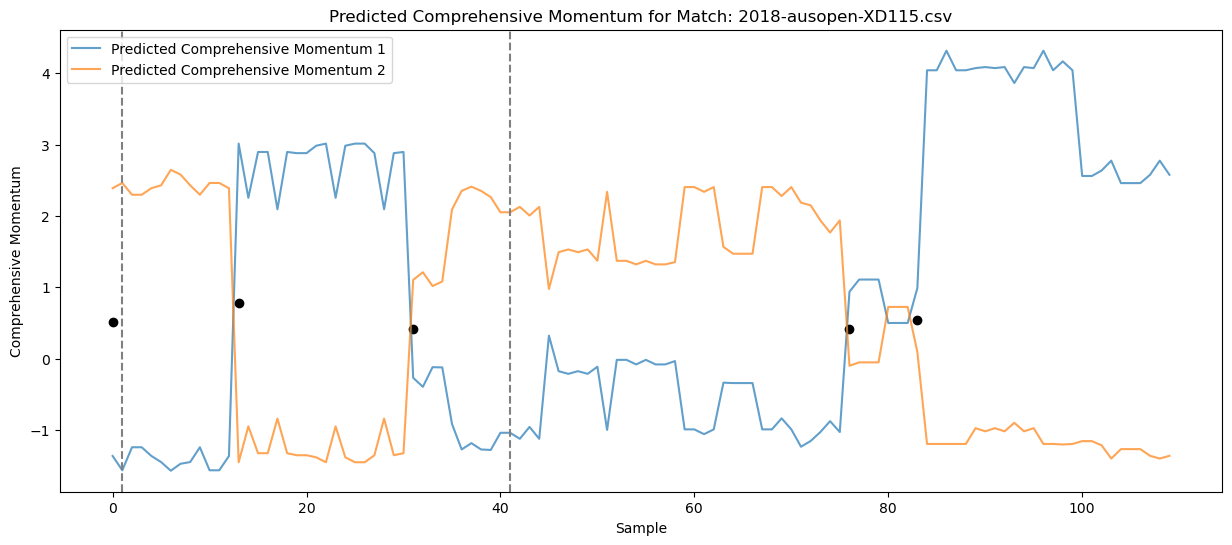

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      108 non-null    int64
 1   p2_sets      108 non-null    int64
 2   p1_games     108 non-null    int64
 3   p2_games     108 non-null    int64
 4   server       108 non-null    int64
 5   speed_mph    108 non-null    int64
 6   rally_count  108 non-null    int64
 7   speed_mph    108 non-null    int64
dtypes: int64(8)
memory usage: 6.9 KB
Match: 2018-ausopen-XD116.csv
Intersection 1: (x=0, y=0.49) - Change in Momentum 1: -0.68, Change in Momentum 2: 0.74
Match: 2018-ausopen-XD116.csv
Intersection 2: (x=38, y=0.58) - Change in Momentum 1: 2.30, Change in Momentum 2: -2.02
Match: 2018-ausopen-XD116.csv
Intersection 3: (x=39, y=0.53) - Change in Momentum 1: -0.62, Change in Momentum 2: 0.52
Match: 2018-ausopen-XD116.csv
Intersection 4: (x=88, y=0.48) - Change in Momentum 1: 1.25, Change in M

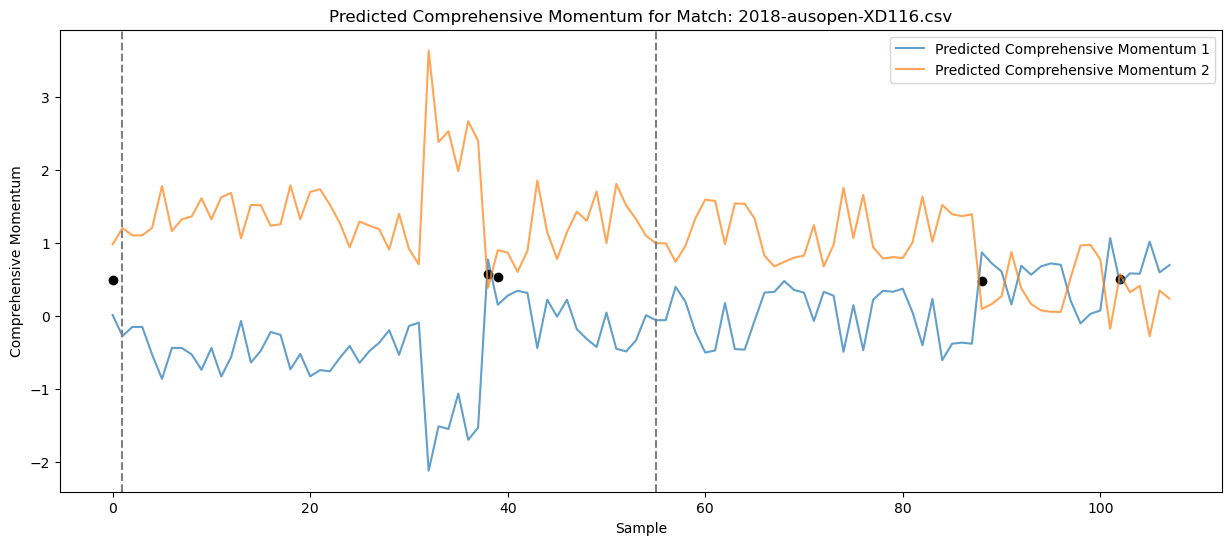

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      142 non-null    int64
 1   p2_sets      142 non-null    int64
 2   p1_games     142 non-null    int64
 3   p2_games     142 non-null    int64
 4   server       142 non-null    int64
 5   speed_mph    142 non-null    int64
 6   rally_count  142 non-null    int64
 7   speed_mph    142 non-null    int64
dtypes: int64(8)
memory usage: 9.0 KB
Match: 2018-ausopen-XD201.csv
Intersection 1: (x=40, y=0.54) - Change in Momentum 1: 1.14, Change in Momentum 2: -0.87
Match: 2018-ausopen-XD201.csv
Intersection 2: (x=57, y=0.59) - Change in Momentum 1: -0.45, Change in Momentum 2: 0.75
Match: 2018-ausopen-XD201.csv
Intersection 3: (x=96, y=0.59) - Change in Momentum 1: 1.46, Change in Momentum 2: -1.27
Match: 2018-ausopen-XD201.csv
Intersection 4: (x=131, y=0.3) - Change in Momentum 1: -0.73, Change in

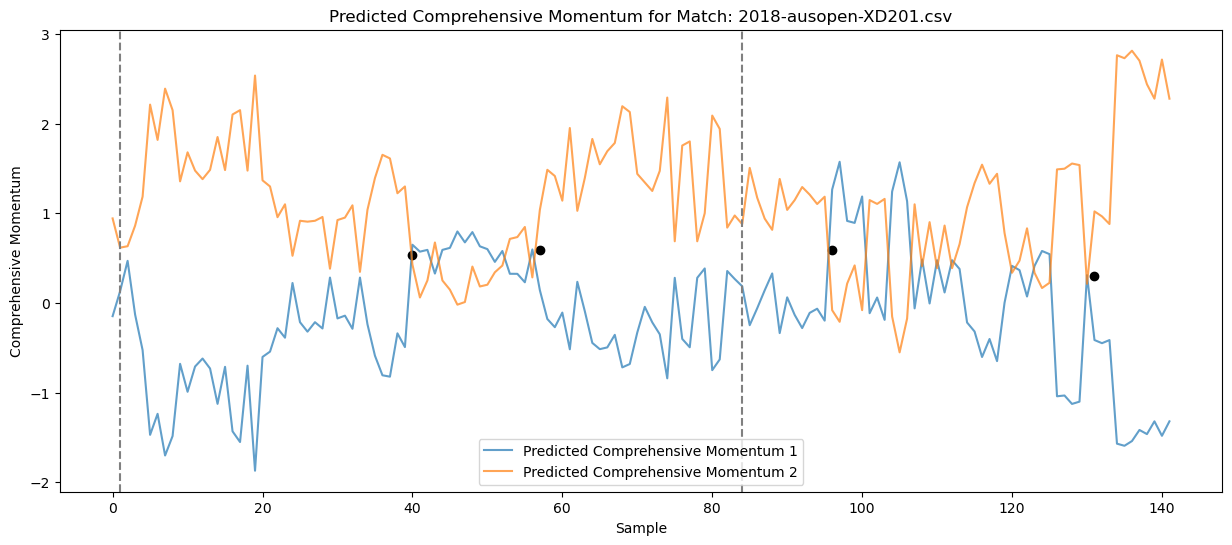

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      77 non-null     int64
 1   p2_sets      77 non-null     int64
 2   p1_games     77 non-null     int64
 3   p2_games     77 non-null     int64
 4   server       77 non-null     int64
 5   speed_mph    77 non-null     int64
 6   rally_count  77 non-null     int64
 7   speed_mph    77 non-null     int64
dtypes: int64(8)
memory usage: 4.9 KB
Match: 2018-ausopen-XD202.csv
Intersection 1: (x=0, y=0.24) - Change in Momentum 1: -1.11, Change in Momentum 2: 0.11
Match: 2018-ausopen-XD202.csv
Intersection 2: (x=19, y=0.72) - Change in Momentum 1: 1.46, Change in Momentum 2: -1.25
Match: 2018-ausopen-XD202.csv
Intersection 3: (x=55, y=0.36) - Change in Momentum 1: 0.29, Change in Momentum 2: -0.86


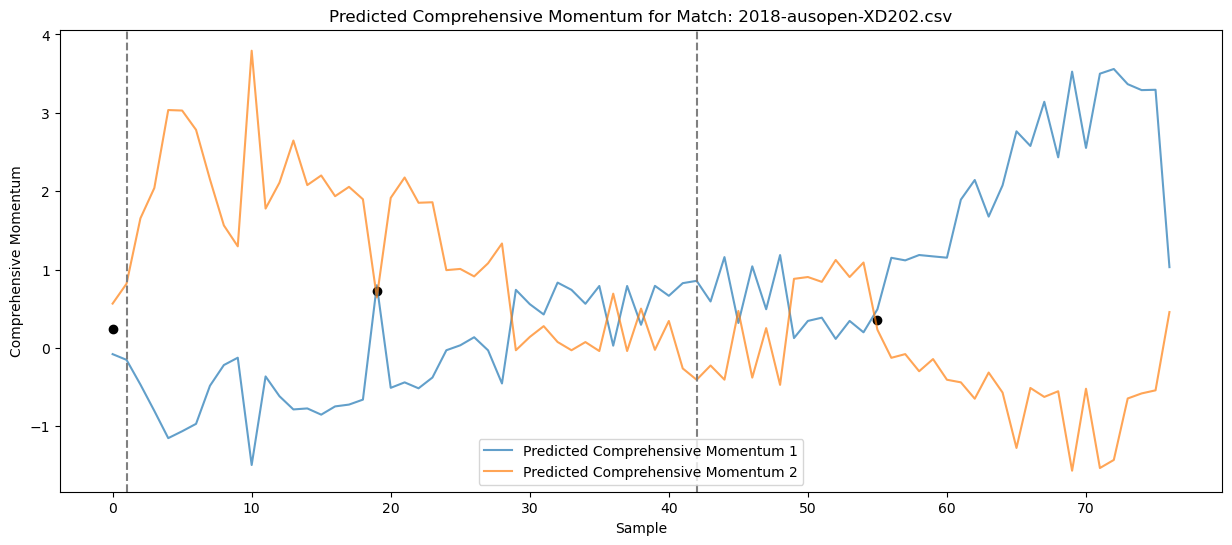

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      123 non-null    int64
 1   p2_sets      123 non-null    int64
 2   p1_games     123 non-null    int64
 3   p2_games     123 non-null    int64
 4   server       123 non-null    int64
 5   speed_mph    123 non-null    int64
 6   rally_count  123 non-null    int64
 7   speed_mph    123 non-null    int64
dtypes: int64(8)
memory usage: 7.8 KB
Match: 2018-ausopen-XD203.csv
Intersection 1: (x=8, y=0.97) - Change in Momentum 1: 4.92, Change in Momentum 2: -3.87
Match: 2018-ausopen-XD203.csv
Intersection 2: (x=47, y=0.52) - Change in Momentum 1: -0.43, Change in Momentum 2: 0.23
Match: 2018-ausopen-XD203.csv
Intersection 3: (x=73, y=0.47) - Change in Momentum 1: -1.88, Change in Momentum 2: 1.78
Match: 2018-ausopen-XD203.csv
Intersection 4: (x=118, y=0.53) - Change in Momentum 1: -1.21, Change in

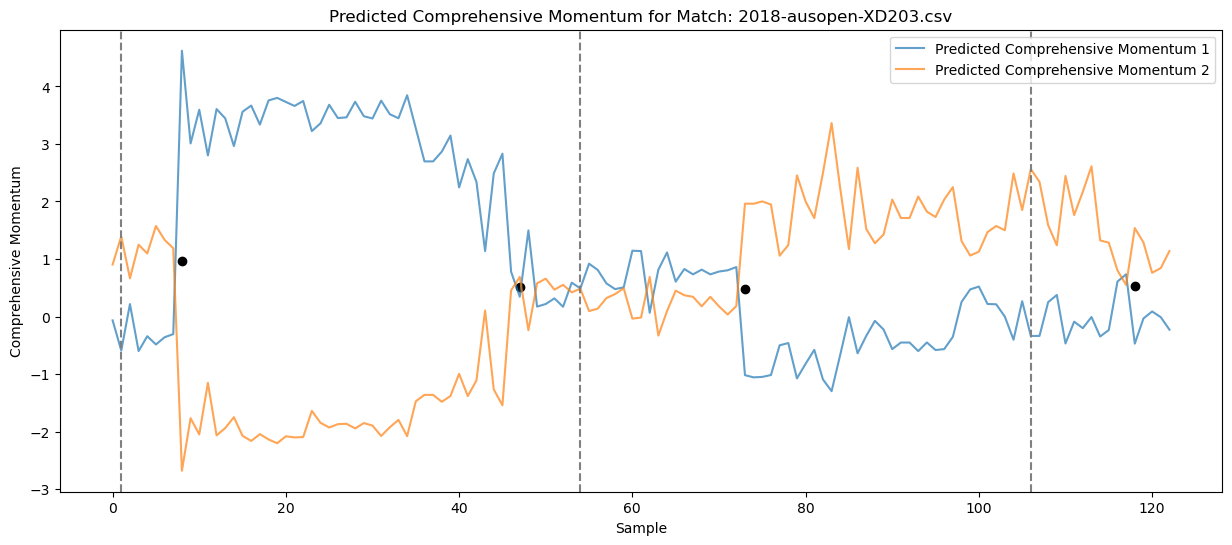

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      107 non-null    int64
 1   p2_sets      107 non-null    int64
 2   p1_games     107 non-null    int64
 3   p2_games     107 non-null    int64
 4   server       107 non-null    int64
 5   speed_mph    107 non-null    int64
 6   rally_count  107 non-null    int64
 7   speed_mph    107 non-null    int64
dtypes: int64(8)
memory usage: 6.8 KB
Match: 2018-ausopen-XD204.csv
Intersection 1: (x=0, y=0.55) - Change in Momentum 1: -1.57, Change in Momentum 2: 1.20
Match: 2018-ausopen-XD204.csv
Intersection 2: (x=1, y=0.45) - Change in Momentum 1: 1.22, Change in Momentum 2: -1.43
Match: 2018-ausopen-XD204.csv
Intersection 3: (x=6, y=0.38) - Change in Momentum 1: 0.26, Change in Momentum 2: -0.33
Match: 2018-ausopen-XD204.csv
Intersection 4: (x=26, y=0.71) - Change in Momentum 1: -4.95, Change in Mo

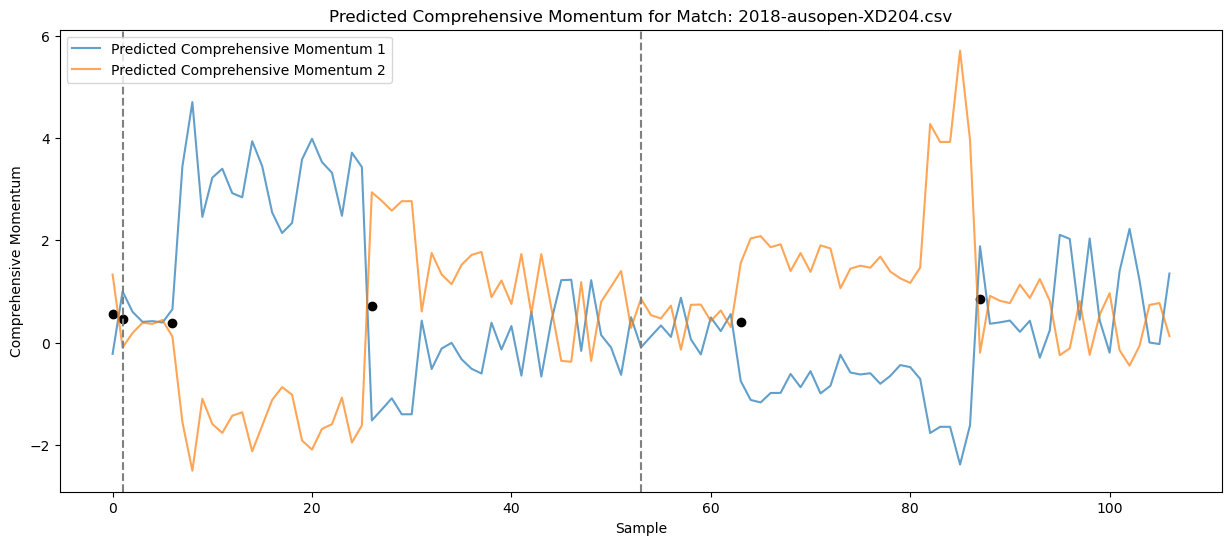

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      108 non-null    int64
 1   p2_sets      108 non-null    int64
 2   p1_games     108 non-null    int64
 3   p2_games     108 non-null    int64
 4   server       108 non-null    int64
 5   speed_mph    108 non-null    int64
 6   rally_count  108 non-null    int64
 7   speed_mph    108 non-null    int64
dtypes: int64(8)
memory usage: 6.9 KB
Match: 2018-ausopen-XD205.csv
Intersection 1: (x=0, y=0.86) - Change in Momentum 1: -2.30, Change in Momentum 2: 2.49
Match: 2018-ausopen-XD205.csv
Intersection 2: (x=6, y=0.66) - Change in Momentum 1: 0.64, Change in Momentum 2: -0.39
Match: 2018-ausopen-XD205.csv
Intersection 3: (x=36, y=0.44) - Change in Momentum 1: 0.97, Change in Momentum 2: -1.35
Match: 2018-ausopen-XD205.csv
Intersection 4: (x=57, y=0.74) - Change in Momentum 1: -0.21, Change in M

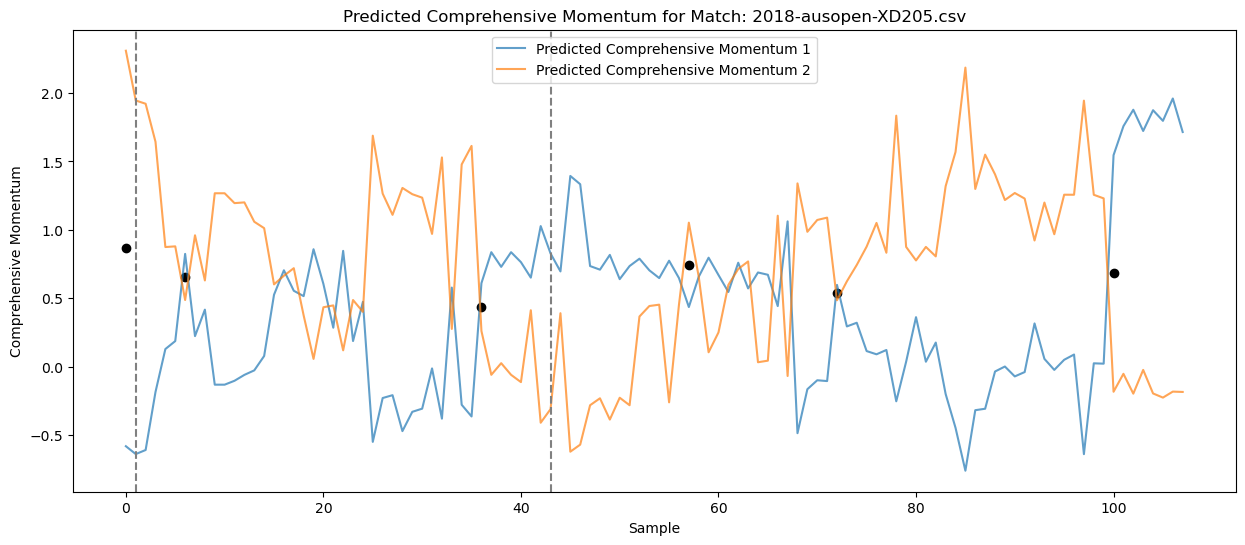

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      139 non-null    int64
 1   p2_sets      139 non-null    int64
 2   p1_games     139 non-null    int64
 3   p2_games     139 non-null    int64
 4   server       139 non-null    int64
 5   speed_mph    139 non-null    int64
 6   rally_count  139 non-null    int64
 7   speed_mph    139 non-null    int64
dtypes: int64(8)
memory usage: 8.8 KB
Match: 2018-ausopen-XD206.csv
Intersection 1: (x=0, y=0.79) - Change in Momentum 1: 4.80, Change in Momentum 2: -4.34
Match: 2018-ausopen-XD206.csv
Intersection 2: (x=28, y=0.53) - Change in Momentum 1: -2.96, Change in Momentum 2: 2.14
Match: 2018-ausopen-XD206.csv
Intersection 3: (x=83, y=0.4) - Change in Momentum 1: -0.89, Change in Momentum 2: 0.94
Match: 2018-ausopen-XD206.csv
Intersection 4: (x=105, y=0.57) - Change in Momentum 1: 2.25, Change in M

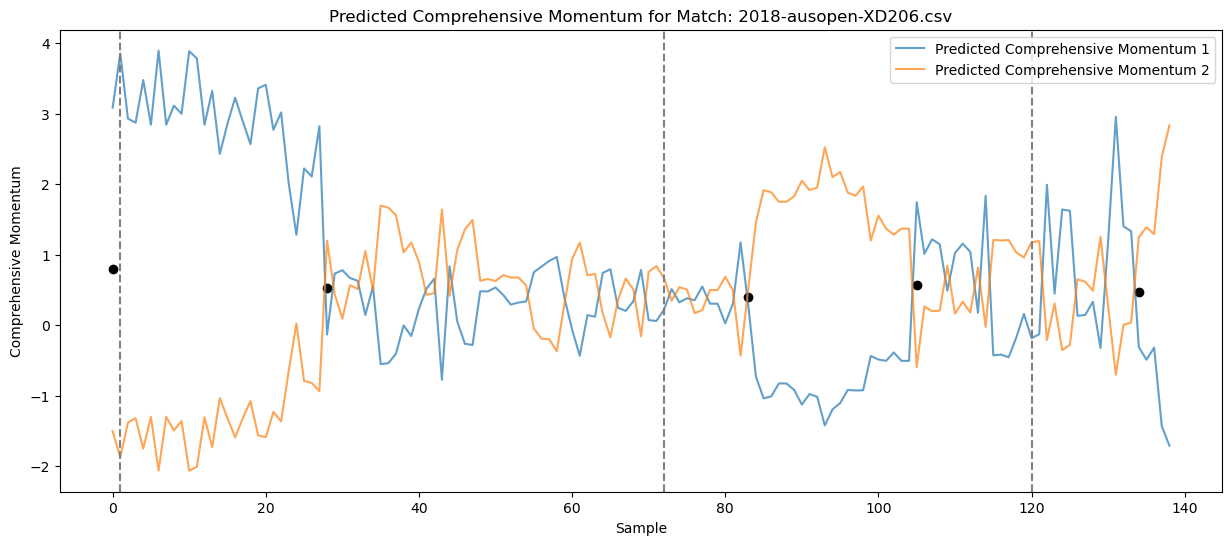

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      95 non-null     int64
 1   p2_sets      95 non-null     int64
 2   p1_games     95 non-null     int64
 3   p2_games     95 non-null     int64
 4   server       95 non-null     int64
 5   speed_mph    95 non-null     int64
 6   rally_count  95 non-null     int64
 7   speed_mph    95 non-null     int64
dtypes: int64(8)
memory usage: 6.1 KB
Match: 2018-ausopen-XD207.csv
Intersection 1: (x=0, y=0.31) - Change in Momentum 1: -1.78, Change in Momentum 2: 1.35
Match: 2018-ausopen-XD207.csv
Intersection 2: (x=14, y=0.62) - Change in Momentum 1: 1.76, Change in Momentum 2: -1.30
Match: 2018-ausopen-XD207.csv
Intersection 3: (x=64, y=0.7) - Change in Momentum 1: 1.37, Change in Momentum 2: -0.77
Match: 2018-ausopen-XD207.csv
Intersection 4: (x=85, y=0.67) - Change in Momentum 1: -0.99, Change in Mom

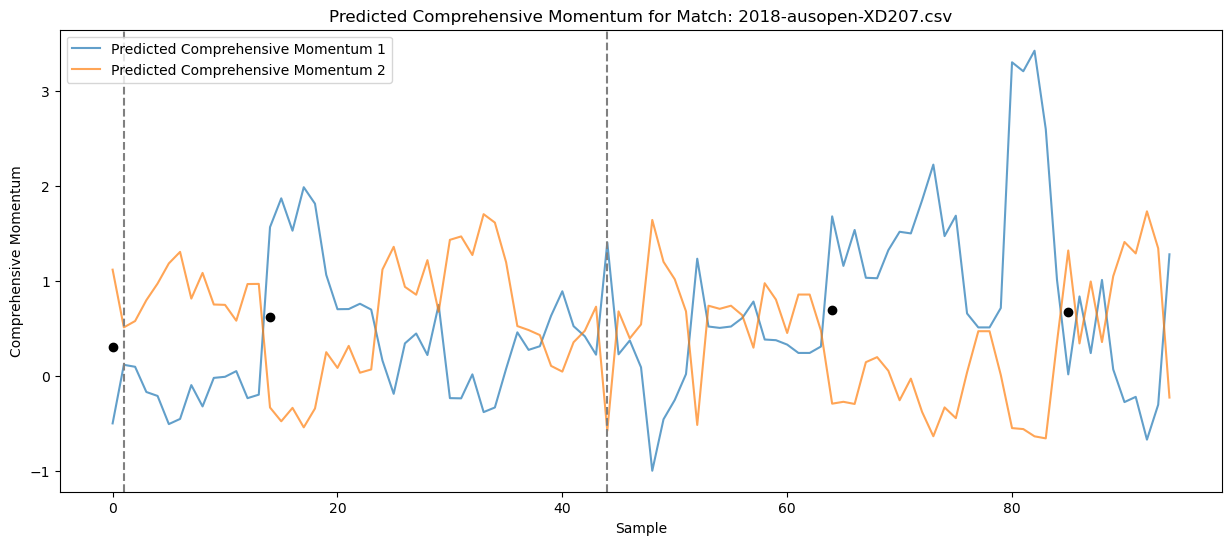

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      128 non-null    int64
 1   p2_sets      128 non-null    int64
 2   p1_games     128 non-null    int64
 3   p2_games     128 non-null    int64
 4   server       128 non-null    int64
 5   speed_mph    128 non-null    int64
 6   rally_count  128 non-null    int64
 7   speed_mph    128 non-null    int64
dtypes: int64(8)
memory usage: 8.1 KB
Match: 2018-ausopen-XD208.csv
Intersection 1: (x=0, y=0.52) - Change in Momentum 1: -0.96, Change in Momentum 2: 0.79
Match: 2018-ausopen-XD208.csv
Intersection 2: (x=8, y=0.53) - Change in Momentum 1: 0.91, Change in Momentum 2: -0.64
Match: 2018-ausopen-XD208.csv
Intersection 3: (x=105, y=0.36) - Change in Momentum 1: 0.38, Change in Momentum 2: -0.40


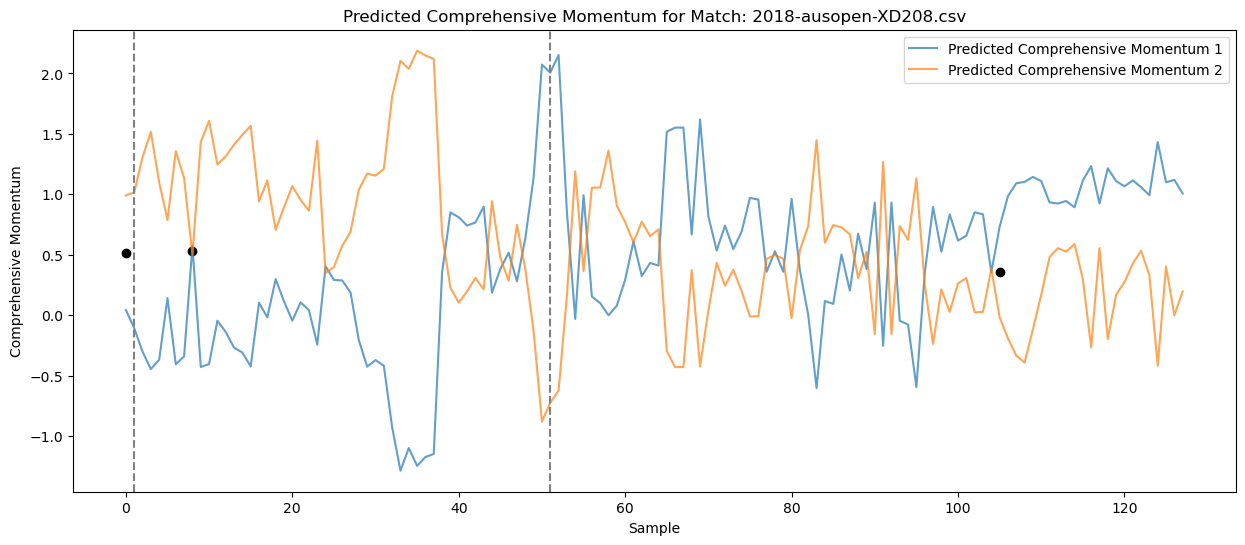

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      129 non-null    int64
 1   p2_sets      129 non-null    int64
 2   p1_games     129 non-null    int64
 3   p2_games     129 non-null    int64
 4   server       129 non-null    int64
 5   speed_mph    129 non-null    int64
 6   rally_count  129 non-null    int64
 7   speed_mph    129 non-null    int64
dtypes: int64(8)
memory usage: 8.2 KB
Match: 2018-ausopen-XD301.csv
Intersection 1: (x=11, y=0.64) - Change in Momentum 1: -4.10, Change in Momentum 2: 4.08
Match: 2018-ausopen-XD301.csv
Intersection 2: (x=51, y=0.24) - Change in Momentum 1: 0.60, Change in Momentum 2: -0.56
Match: 2018-ausopen-XD301.csv
Intersection 3: (x=72, y=0.31) - Change in Momentum 1: 0.63, Change in Momentum 2: -0.99


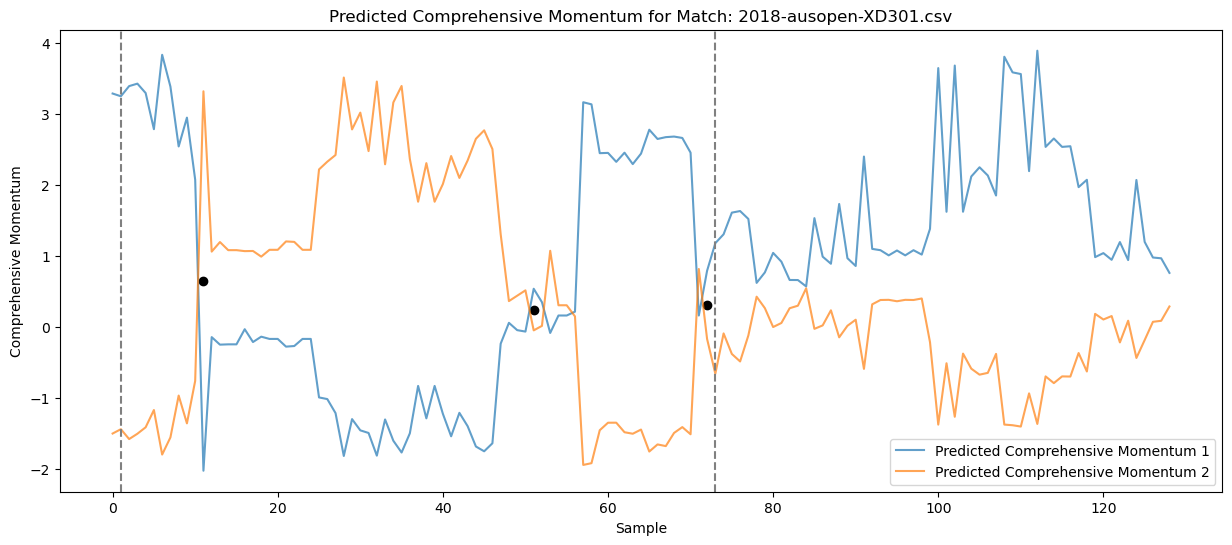

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      141 non-null    int64
 1   p2_sets      141 non-null    int64
 2   p1_games     141 non-null    int64
 3   p2_games     141 non-null    int64
 4   server       141 non-null    int64
 5   speed_mph    141 non-null    int64
 6   rally_count  141 non-null    int64
 7   speed_mph    141 non-null    int64
dtypes: int64(8)
memory usage: 8.9 KB
Match: 2018-ausopen-XD302.csv
Intersection 1: (x=1, y=0.46) - Change in Momentum 1: -1.05, Change in Momentum 2: 1.19
Match: 2018-ausopen-XD302.csv
Intersection 2: (x=38, y=0.41) - Change in Momentum 1: -0.71, Change in Momentum 2: 0.84
Match: 2018-ausopen-XD302.csv
Intersection 3: (x=65, y=0.66) - Change in Momentum 1: 1.89, Change in Momentum 2: -1.22
Match: 2018-ausopen-XD302.csv
Intersection 4: (x=74, y=0.31) - Change in Momentum 1: 0.48, Change in M

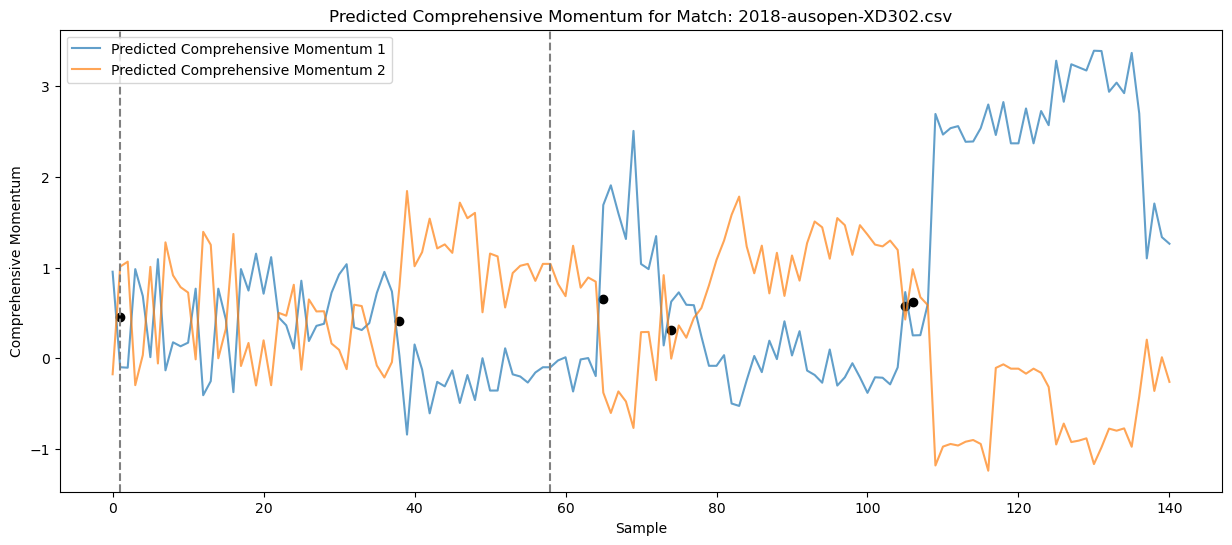

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      120 non-null    int64
 1   p2_sets      120 non-null    int64
 2   p1_games     120 non-null    int64
 3   p2_games     120 non-null    int64
 4   server       120 non-null    int64
 5   speed_mph    120 non-null    int64
 6   rally_count  120 non-null    int64
 7   speed_mph    120 non-null    int64
dtypes: int64(8)
memory usage: 7.6 KB
Match: 2018-ausopen-XD303.csv
Intersection 1: (x=23, y=0.56) - Change in Momentum 1: -0.29, Change in Momentum 2: 0.38
Match: 2018-ausopen-XD303.csv
Intersection 2: (x=55, y=0.26) - Change in Momentum 1: -0.59, Change in Momentum 2: 0.58
Match: 2018-ausopen-XD303.csv
Intersection 3: (x=81, y=0.63) - Change in Momentum 1: 3.62, Change in Momentum 2: -3.13
Match: 2018-ausopen-XD303.csv
Intersection 4: (x=107, y=0.99) - Change in Momentum 1: -0.50, Change i

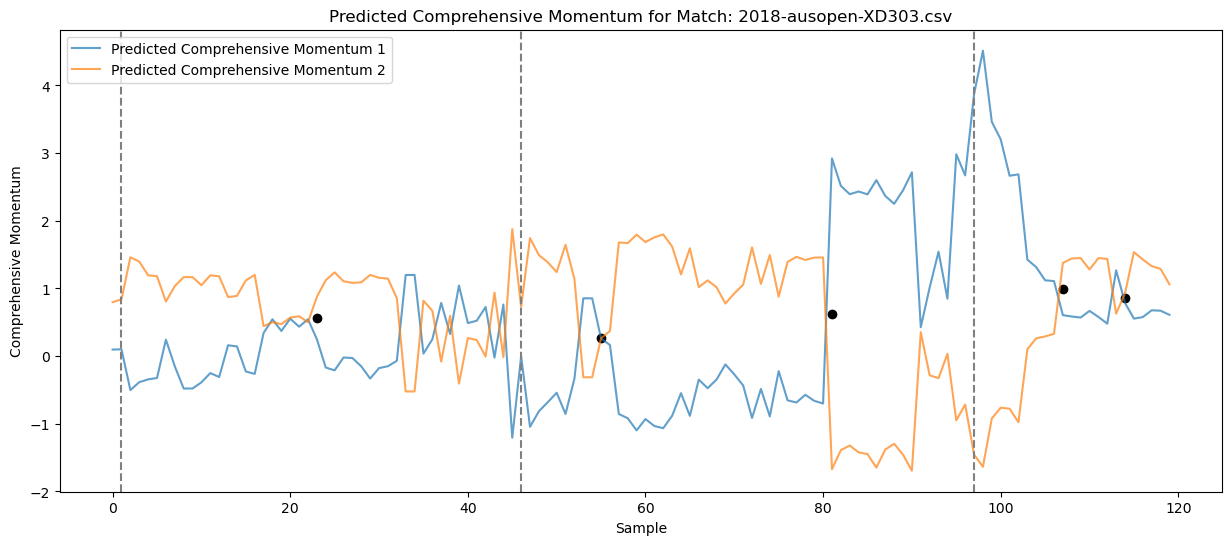

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      123 non-null    int64
 1   p2_sets      123 non-null    int64
 2   p1_games     123 non-null    int64
 3   p2_games     123 non-null    int64
 4   server       123 non-null    int64
 5   speed_mph    123 non-null    int64
 6   rally_count  123 non-null    int64
 7   speed_mph    123 non-null    int64
dtypes: int64(8)
memory usage: 7.8 KB
Match: 2018-ausopen-XD304.csv
Intersection 1: (x=14, y=0.44) - Change in Momentum 1: 0.89, Change in Momentum 2: -0.91
Match: 2018-ausopen-XD304.csv
Intersection 2: (x=15, y=0.47) - Change in Momentum 1: -0.69, Change in Momentum 2: 0.76
Match: 2018-ausopen-XD304.csv
Intersection 3: (x=36, y=0.45) - Change in Momentum 1: 0.42, Change in Momentum 2: -0.48
Match: 2018-ausopen-XD304.csv
Intersection 4: (x=57, y=0.46) - Change in Momentum 1: 1.56, Change in 

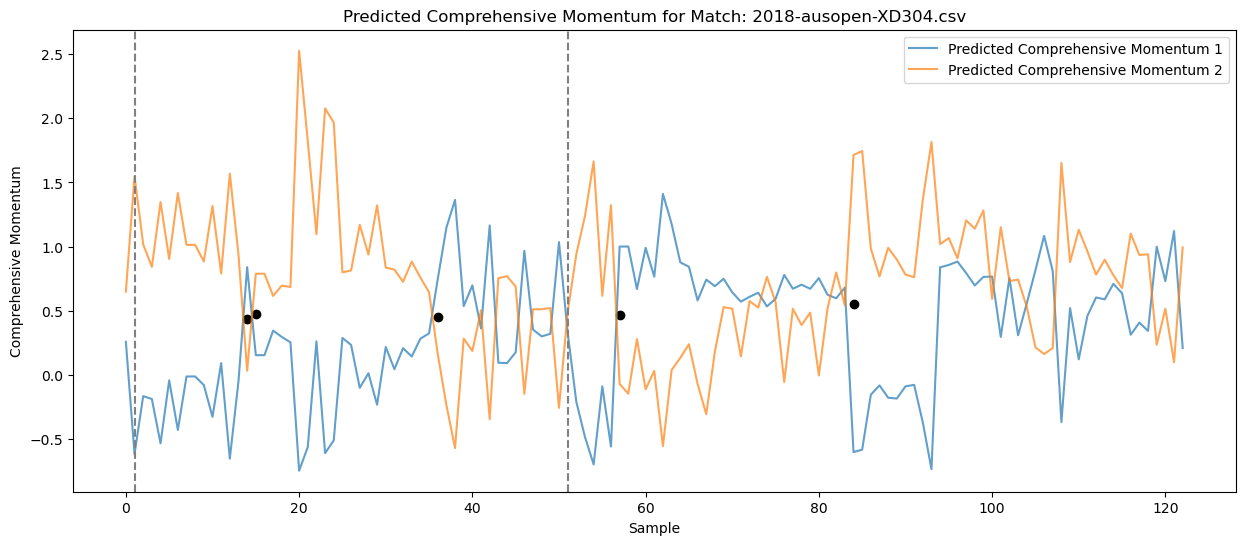

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      144 non-null    int64
 1   p2_sets      144 non-null    int64
 2   p1_games     144 non-null    int64
 3   p2_games     144 non-null    int64
 4   server       144 non-null    int64
 5   speed_mph    144 non-null    int64
 6   rally_count  144 non-null    int64
 7   speed_mph    144 non-null    int64
dtypes: int64(8)
memory usage: 9.1 KB
Match: 2018-ausopen-XD401.csv
Intersection 1: (x=4, y=0.5) - Change in Momentum 1: 1.18, Change in Momentum 2: -1.17
Match: 2018-ausopen-XD401.csv
Intersection 2: (x=87, y=0.5) - Change in Momentum 1: 0.22, Change in Momentum 2: -0.54
Match: 2018-ausopen-XD401.csv
Intersection 3: (x=140, y=0.53) - Change in Momentum 1: -2.25, Change in Momentum 2: 1.42


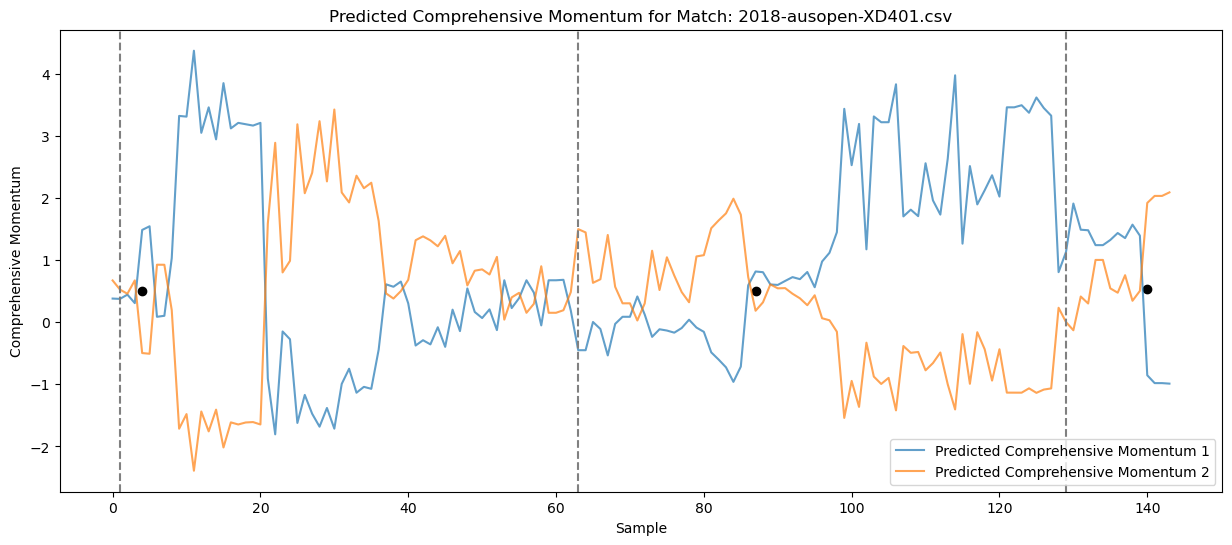

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      96 non-null     int64
 1   p2_sets      96 non-null     int64
 2   p1_games     96 non-null     int64
 3   p2_games     96 non-null     int64
 4   server       96 non-null     int64
 5   speed_mph    96 non-null     int64
 6   rally_count  96 non-null     int64
 7   speed_mph    96 non-null     int64
dtypes: int64(8)
memory usage: 6.1 KB
Match: 2018-ausopen-XD402.csv
Intersection 1: (x=0, y=0.89) - Change in Momentum 1: 4.88, Change in Momentum 2: -4.19
Match: 2018-ausopen-XD402.csv
Intersection 2: (x=2, y=0.55) - Change in Momentum 1: -3.95, Change in Momentum 2: 3.48
Match: 2018-ausopen-XD402.csv
Intersection 3: (x=31, y=0.71) - Change in Momentum 1: 3.93, Change in Momentum 2: -3.08


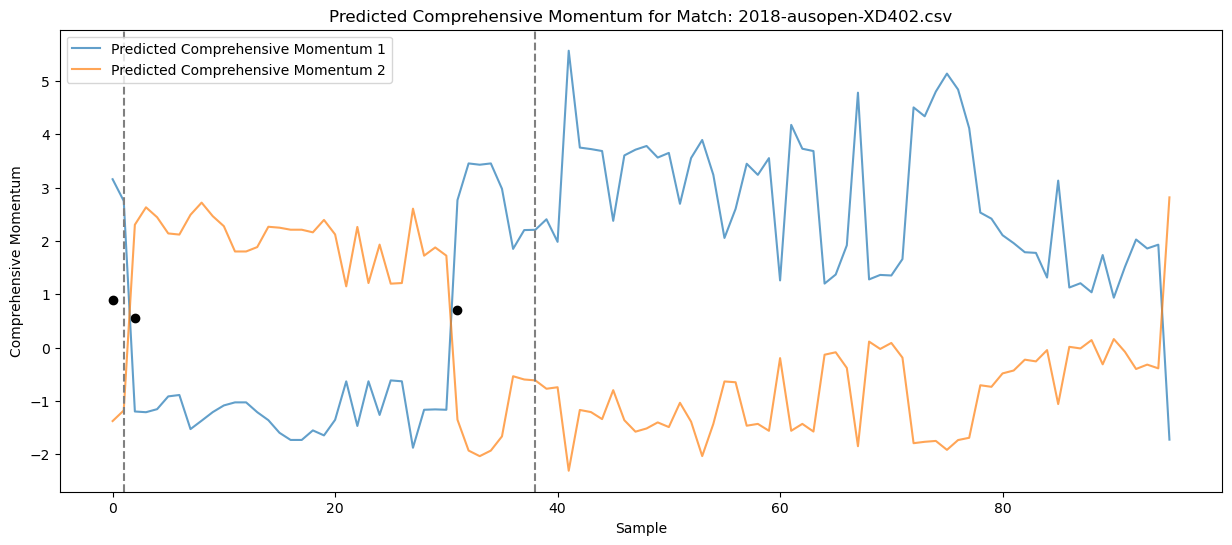

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   p1_sets      116 non-null    int64
 1   p2_sets      116 non-null    int64
 2   p1_games     116 non-null    int64
 3   p2_games     116 non-null    int64
 4   server       116 non-null    int64
 5   speed_mph    116 non-null    int64
 6   rally_count  116 non-null    int64
 7   speed_mph    116 non-null    int64
dtypes: int64(8)
memory usage: 7.4 KB
Match: 2018-ausopen-XD501.csv
Intersection 1: (x=9, y=0.59) - Change in Momentum 1: -2.67, Change in Momentum 2: 2.45
Match: 2018-ausopen-XD501.csv
Intersection 2: (x=106, y=0.89) - Change in Momentum 1: 3.19, Change in Momentum 2: -2.58


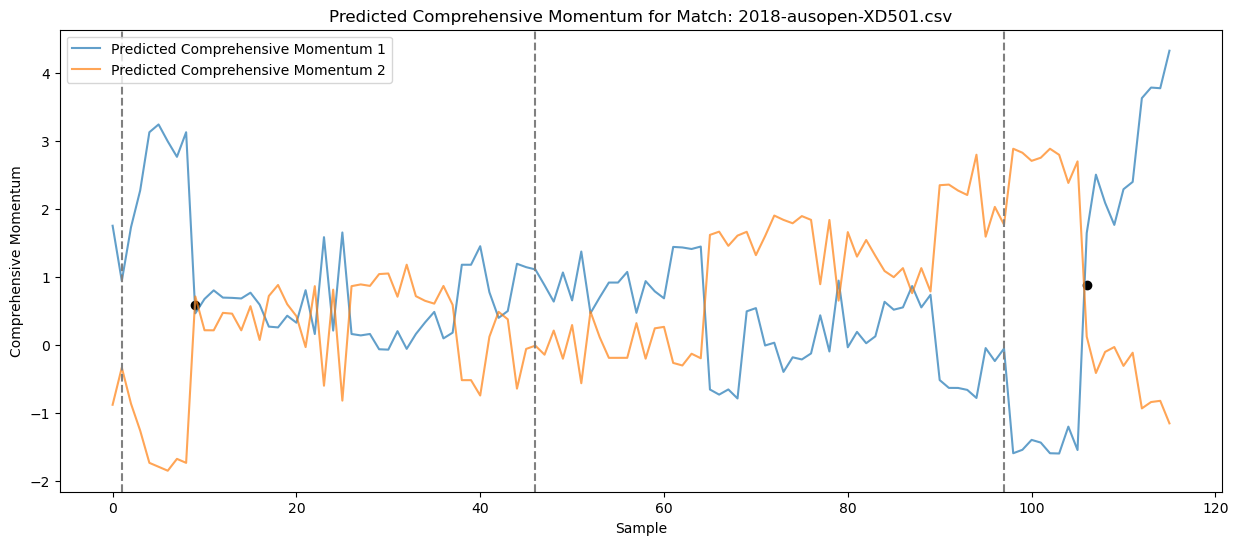

In [15]:
"""
预测模型
"""
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

folder_path = 'data_2018'
file_list = glob.glob(f'{folder_path}/2018-ausopen-*.csv')
dataframes = [pd.read_csv(file) for file in file_list]
combined_df = pd.concat(dataframes, ignore_index=True)

intersections_data = []
feature_columns = ['p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server', 'speed_mph', 'rally_count', 'speed_mph']

intersections_feature = ['p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'rally_count', 'speed_mph', 'server']


# 重新训练模型
y = combined_df[['comprehensive_momentum_1', 'comprehensive_momentum_2']]
X = combined_df[feature_columns].copy()
for column in feature_columns:
    X[column].fillna(X[column].mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

"""
选择模型
"""
model = RandomForestRegressor()

# 训练模型
model.fit(X_train, y_train)

# 测试集预测
y_pred = model.predict(X_test)

# 为每场比赛单独进行预测并绘制曲线
for file in file_list:
    df = pd.read_csv(file)

    # 创建特征列的副本来处理缺失值
    features_df = df[feature_columns].copy()
    features_df = features_df.apply(pd.to_numeric, errors='coerce')
    features_df.fillna(features_df.mean(), inplace=True)

    # 检查是否还有缺失值
    if features_df.isnull().values.any():
        # print(f"Warning: Missing values detected in file {file}.")
        features_df.fillna(features_df.mean(), inplace=True)
    
    features_df.info()
    
    # 标准化
    scaler = StandardScaler()
    X_match = scaler.fit_transform(features_df)
    
    # # 读取保存的模型
    # model = joblib.load('prediction_model.pkl')

    # 预测
    y_pred_match = model.predict(X_match)
    
    # 寻找交点
    intersections = find_intersections_and_changes(y_pred_match[:, 0], y_pred_match[:, 1])

    # 收集交点信息及相应的特征
    for i, (x, y, change_1, change_2) in enumerate(intersections):
        match_name = os.path.basename(file)
        label = 1 if change_1 > 0 else 0  # Player1的change由坏转好为1，由好转坏为0
        intersection_info = {'Label': label}
    
        # 提取相应样本的特征值
        for feature in intersections_feature:
            intersection_info[feature] = features_df.loc[x, feature]
    
        intersections_data.append(intersection_info)
    
    # 将收集到的数据转换为DataFrame
    intersections_df = pd.DataFrame(intersections_data)
    
    # 保存交点信息到新表
    intersections_df.to_csv('intersections_data_1.csv', index=False)



    # 打印交点信息和分数变化
    for i, (x, y, change_1, change_2) in enumerate(intersections, 1):        
        print(f"Match: {os.path.basename(file)}")
        print(f"Intersection {i}: (x={x}, y={round(y, 2)}) - Change in Momentum 1: {change_1:.2f}, Change in Momentum 2: {change_2:.2f}")

    # 绘制曲线
    plt.figure(figsize=(15, 6))
    plt.plot(y_pred_match[:, 0], label='Predicted Comprehensive Momentum 1', alpha=0.7)
    plt.plot(y_pred_match[:, 1], label='Predicted Comprehensive Momentum 2', alpha=0.7)
    
    # 添加盘结束的垂直线
    last_set_no = 0
    for i, row in df.iterrows():
        if row['set_no'] != last_set_no:
            plt.axvline(x=row['point_no'], color='grey', linestyle='--')
            last_set_no = row['set_no']
    
    for x, y, _, _ in intersections:
        plt.scatter(x, y, color='black')
    plt.title(f'Predicted Comprehensive Momentum for Match: {os.path.basename(file)}')
    plt.xlabel('Sample')
    plt.ylabel('Comprehensive Momentum')
    plt.legend()
    plt.show()